In [ ]:
'''Extract mass and metallicity history from Dusty-SAGE output'''

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import h5py

In [4]:
from random import sample, seed
import copy
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=73, Om0=0.25)
import matplotlib.patheffects as PathEffects

In [5]:
from __future__ import print_function
from os.path import dirname, abspath, join as pjoin
import Corrfunc
from Corrfunc.theory.xi import xi
import re, os

In [6]:
%load_ext line_profiler

In [7]:
def galdtype_dusty(align):
     
    '''Define the data-type for the public version of Dusty-SAGE'''
    
    Galdesc_full = [
        ('SnapNum'                      , np.int32),
        ('Type'                         , np.int32),
        ('GalaxyIndex'                  , np.int64),
        ('CentralGalaxyIndex'           , np.int64),
        ('SAGEHaloIndex'                , np.int32),
        ('SAGETreeIndex'                , np.int32),
        ('SimulationHaloIndex'          , np.int64),
        ('mergeType'                    , np.int32),
        ('mergeIntoID'                  , np.int32),
        ('mergeIntoSnapNum'             , np.int32),
        ('dT'                           , np.float32),
        ('Pos'                          , (np.float32, 3)),
        ('Vel'                          , (np.float32, 3)),
        ('Spin'                         , (np.float32, 3)),
        ('Len'                          , np.int32),
        ('Mvir'                         , np.float32),
        ('CentralMvir'                  , np.float32),
        ('Rvir'                         , np.float32),
        ('Vvir'                         , np.float32),
        ('Vmax'                         , np.float32),
        ('VelDisp'                      , np.float32),
        ('ColdGas'                      , np.float32),
        ('f_H2'                         , np.float32),
        ('f_HI'                         , np.float32),
        ('cf'                           , np.float32),
        ('Zp'                           , np.float32),
        ('Pressure'                     , np.float32),
        ('StellarMass'                  , np.float32),
        ('BulgeMass'                    , np.float32),
        ('BulgeInstability'             , np.float32),
        ('HotGas'                       , np.float32),
        ('EjectedMass'                  , np.float32),
        ('BlackHoleMass'                , np.float32),
        ('IntraClusterStars'            , np.float32),
        ('MetalsColdGas'                , np.float32),
        ('MetalsStellarMass'            , np.float32),
        ('MetalsBulgeMass'              , np.float32),
        ('MetalsHotGas'                 , np.float32),
        ('MetalsEjectedMass'            , np.float32),
        ('MetalsIntraClusterStars'      , np.float32),
        ('ColdDust'                     , np.float32),
        ('HotDust'                      , np.float32),
        ('EjectedDust'                     , np.float32),
        ('SfrDisk'                      , np.float32),
        ('SfrBulge'                     , np.float32),
        ('SfrDiskZ'                     , np.float32),
        ('SfrBulgeZ'                    , np.float32),
        ('SfrDiskDTG'                     , np.float32),
        ('SfrBulgeDTG'                    , np.float32),
        ('dustdotform'                  , np.float32),
        ('dustdotgrowth'                    , np.float32),
        ('dustdotdestruct'                    , np.float32),
#        ('Sfr'                          , (np.float32, 64)),
        ('DiskRadius'                   , np.float32),
        ('Cooling'                      , np.float32),
        ('Heating'                      , np.float32),
        ('QuasarModeBHaccretionMass'    , np.float32),
        ('TimeOfLastMajorMerger'         , np.float32),
        ('TimeOfLastMinorMerger'         , np.float32),
        ('OutflowRate'                  , np.float32),
        ('infallMvir'                   , np.float32),
        ('infallVvir'                   , np.float32),
        ('infallVmax'                   , np.float32)
        ]
    names = [Galdesc_full[i][0] for i in range(len(Galdesc_full))]
    formats = [Galdesc_full[i][1] for i in range(len(Galdesc_full))]
    if(align==True):
        Galdesc = np.dtype({'names':names, 'formats':formats}, align=True)
    else:
        Galdesc = np.dtype({'names':names, 'formats':formats})
    return Galdesc

In [8]:
def galdtype(align):
    
    '''Define the data-type for the public version of SAGE'''
    
    Galdesc_full = [
        ('SnapNum'                      , np.int32),
        ('Type'                         , np.int32),
        ('GalaxyIndex'                  , np.int64),
        ('CentralGalaxyIndex'           , np.int64),
        ('SAGEHaloIndex'                , np.int32),
        ('SAGETreeIndex'                , np.int32),
        ('SimulationHaloIndex'          , np.int64),
        ('mergeType'                    , np.int32),
        ('mergeIntoID'                  , np.int32),
        ('mergeIntoSnapNum'             , np.int32),
        ('dT'                           , np.float32),
        ('Pos'                          , (np.float32, 3)),
        ('Vel'                          , (np.float32, 3)),
        ('Spin'                         , (np.float32, 3)),
        ('Len'                          , np.int32),
        ('Mvir'                         , np.float32),
        ('CentralMvir'                  , np.float32),
        ('Rvir'                         , np.float32),
        ('Vvir'                         , np.float32),
        ('Vmax'                         , np.float32),
        ('VelDisp'                      , np.float32),
        ('ColdGas'                      , np.float32),
        ('StellarMass'                  , np.float32),
        ('BulgeMass'                    , np.float32),
        ('HotGas'                       , np.float32),
        ('EjectedMass'                  , np.float32),
        ('BlackHoleMass'                , np.float32),
        ('IntraClusterStars'            , np.float32),
        ('MetalsColdGas'                , np.float32),
        ('MetalsStellarMass'            , np.float32),
        ('MetalsBulgeMass'              , np.float32),
        ('MetalsHotGas'                 , np.float32),
        ('MetalsEjectedMass'            , np.float32),
        ('MetalsIntraClusterStars'      , np.float32),
        ('SfrDisk'                      , np.float32),
        ('SfrBulge'                     , np.float32),
        ('SfrDiskZ'                     , np.float32),
        ('SfrBulgeZ'                    , np.float32),
        ('DiskRadius'                   , np.float32),
        ('Cooling'                      , np.float32),
        ('Heating'                      , np.float32),
        ('QuasarModeBHaccretionMass'    , np.float32),
        ('TimeOfLastMajorMerger'         , np.float32),
        ('TimeOfLastMinorMerger'         , np.float32),
        ('OutflowRate'                  , np.float32),
        ('infallMvir'                   , np.float32),
        ('infallVvir'                   , np.float32),
        ('infallVmax'                   , np.float32)
        ]
    names = [Galdesc_full[i][0] for i in range(len(Galdesc_full))]
    formats = [Galdesc_full[i][1] for i in range(len(Galdesc_full))]
    if(align==True):
        Galdesc = np.dtype({'names':names, 'formats':formats}, align=True)
    else:
        Galdesc = np.dtype({'names':names, 'formats':formats})
    return Galdesc

In [9]:
def iterate_trees(SAM_option, directory, firstfile, lastfile):
    '''
    Iterating trees from the simulation output.
    Currently, it can only read trees from SAGE (Croton et al. 2006, 2016)
    and dusty-sage (Triani et al. 2020)
    
    Input:  - SAM option (int): (0) SAGE (1) Dusty-SAGE
            - path of the directory containing simulation output (string).
              Format of the simulation output: model_zX.XXX_Y
              X.XXX : redshift of the snapshot
              Y : file number
    
    Output: a tree, consist of properties of galaxies listed in galdtype_dusty() for Dusty SAGE or galdtype() for SAGE
    '''
    
    #define variables
    entries = [e for e in os.listdir(directory) 
               if os.path.isfile(os.path.join(directory, e))]
    entries = [e for e in entries if e.startswith('model_z')]
    redshift_strings = list(set([re.match(r'model_z(\d+\.?\d*)_\d+', e).group(1)
                                for e in entries]))
#    group_strings = list(set([re.match(r'model_z\d+\.?\d*_(\d+)', e).group(1)
#                            for e in entries]))
    
#    group_strings.sort(key=lambda x: int(x))
    redshift_strings.sort(key=lambda x: float(x), reverse=True)
    
    if SAM_option == 0:
        Galdesc_false = galdtype(align=False)
        Galdesc=galdtype(align=True)
    elif SAM_option == 1:
        Galdesc_false = galdtype_dusty(align=False)
        Galdesc=galdtype_dusty(align=True)
    else:
        print("Choose a SAM: 0 - for SAGE, 1 - for Dusty-SAGE")
    
    #open files
    for group in range(firstfile, lastfile+1):
#    for group in group_strings:
        files = []
        for redshift in redshift_strings:
            fn = 'model_z%s_%s' % (redshift, group)
            files.append(open(os.path.join(directory, fn), 'rb'))

        n_trees = [np.fromfile(f, np.uint32, 1)[0] for f in files][0]
        n_gals = [np.fromfile(f, np.uint32, 1)[0] for f in files]
        chunk_sizes = [np.fromfile(f, np.uint32, n_trees) for f in files]
        tree_sizes = sum(chunk_sizes, axis=0)
        
        for ii in range(n_trees):
            tree_size = tree_sizes[ii]
            tree = np.empty(tree_size, dtype=Galdesc_false)
            offs=0
            for jj in range(len(chunk_sizes)):
                chunk_size = chunk_sizes[jj][ii]
                if chunk_size <= 0: continue

                data = np.fromfile(files[jj], Galdesc, chunk_size)

                for _v in data.dtype.names:
                    tree[_v][offs:offs+chunk_size] = data[_v]
                offs += chunk_size

            # First validate ID's.
            for f in ['Type', 'GalaxyIndex', 'CentralGalaxyIndex']:
                if min(tree[f]) < 0:
                    print("ERROR; min(tree[{0}]) = {1} should be non-zero"
                            .format(f, min(tree[f])))
                    raise ValueError()

            # Validate central galaxy index (unique id, generated by sage)
            ind = (np.where(tree['Type'] == 0))[0]
            if not bool(np.all(tree['GalaxyIndex'][ind] == tree['CentralGalaxyIndex'][ind])):
                print("tree[GalaxyIndex][ind] = {0}".format(tree['GalaxyIndex'][ind]))
                print("tree[CentralGalaxyIndex][ind] = {0}".format(tree['CentralGalaxyIndex'][ind]))

            assert bool(np.all(tree['GalaxyIndex'][ind] ==
                            tree['CentralGalaxyIndex'][ind])), \
                "Central Galaxy Index must equal Galaxy Index for centrals"

            yield tree
            
        for file in files:
            file.close()

In [10]:
def calculate_mass_and_metals(SAM_choice, tree, snap_limit):
    
    """Calculate mass history from Dusty-SAGE tree.
    In one fly, it will calculate the mass and metals history of a tree while mapping
    the descendant.
    
    Input:  - SAM_choice (int): (0) SAGE (1) Dusty-SAGE
            - a tree yielded by iterate_tree(directory)
            - snap_limit (int) -- last snapshot of the tree
    Output: 3-dimensions array.
            1st array (NxM)*: Stellar mass history of the tree (in Msun/h)
            2nd array (NxM)*: Stellar metallicity history (no unit)
            
            * N is the number of galaxies
              M is the number of snapshot, ascending with increasing age of Universe.
    """
    
    recycle_fraction = 0.43
    sorted_idx = np.argsort(tree, order=('GalaxyIndex', 'SnapNum'))
    all_gal_ID = tree['GalaxyIndex']
    snapshot_nr = tree['SnapNum']
    merge_idx = tree['mergeIntoID']
    merge_snapshot = tree['mergeIntoSnapNum']
    merge_type = tree['mergeType']

    delta_bulge = tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
    delta_disk = tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
    delta_mass = delta_bulge + delta_disk

    
    if SAM_choice == 0:
        delta_bulge_metals = tree['SfrBulgeZ']  * tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_disk_metals = tree['SfrDiskZ'] * tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_metals = delta_bulge_metals + delta_disk_metals 

    elif SAM_choice == 1:
        delta_bulge_metals = tree['SfrBulgeZ']  * tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_disk_metals = tree['SfrDiskZ'] * tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_bulge_dust = tree['SfrBulgeDTG'] * tree['SfrBulge'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_disk_dust = tree['SfrDiskDTG'] * tree['SfrDisk'] * tree['dT'] * 1.e6 * (1.0 - recycle_fraction)
        delta_metals = delta_bulge_metals + delta_disk_metals + delta_bulge_dust + delta_disk_dust
    else:
        print("Choose a SAM: 0 - for SAGE, 1 - for Dusty-SAGE")
    
    unique_ID = np.unique(all_gal_ID)
    mass = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    metals = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    dust = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    
    #map descendant and build mass and metal history
    for kk, gal_ID in enumerate(unique_ID):
        instant_mass = 0.0
        instant_metals = 0.0
        for ii, ID in enumerate(all_gal_ID[sorted_idx]):
            if(gal_ID == ID):
                instant_mass += delta_mass[sorted_idx[ii]] 
                mass[kk][snapshot_nr[sorted_idx[ii]]] = instant_mass
                assert mass[kk][snapshot_nr[sorted_idx[ii]]] >= mass[kk][snapshot_nr[sorted_idx[ii-1]]]
                
                instant_metals += delta_metals[sorted_idx[ii]]
                metals[kk][snapshot_nr[sorted_idx[ii]]] = instant_metals
                assert metals[kk][snapshot_nr[sorted_idx[ii]]] >= metals[kk][snapshot_nr[sorted_idx[ii-1]]]
                
    
    #make sure the mass and metals are increasing with snapshot_nr   
    for i in range(len(unique_ID)):
        for j in range(max(snapshot_nr)):
            if (mass[i][j+1] < mass[i][j]):
                mass[i][j+1] = mass[i][j]
                
            if (metals[i][j+1] < metals[i][j]):
                metals[i][j+1] = metals[i][j]
            
    #identify merger and add mass
    for snap in range(max(snapshot_nr)+1):
        wsnap = np.where(snapshot_nr == snap)[0]
        wmerge = np.where((merge_idx[wsnap] != -1) & (merge_snapshot[wsnap] < snap_limit) & (merge_type[wsnap] < 3))[0] #only include major (merge_type=1) and minor (merge_type=2) merger
        merger_snap = merge_snapshot[wsnap][wmerge]
        merger_id = merge_idx[wsnap][wmerge]
        
        if len(merger_id) > 0:
            for i, idx in enumerate(merger_id):
                
                wmergesnap = np.where(snapshot_nr == merger_snap[i])[0]
                central_ID = all_gal_ID[wmergesnap][idx]
                central_idx = np.where(unique_ID[:,None] == central_ID)[0]
                satellite_ID = all_gal_ID[wsnap][wmerge][i]
                satellite_idx = np.where(unique_ID[:,None] == satellite_ID)[0]
                
                #added satellite mass to central mass
                mass[central_idx] = mass[central_idx] + mass[satellite_idx]
            
                #eliminate the mass of satellite galaxies
                mass[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                
                #added satellite metals to central
                metals[central_idx] = metals[central_idx] + metals[satellite_idx]
                
                #eliminate the metals of satellite galaxies
                metals[satellite_idx] = np.zeros(max(snapshot_nr)+1)
               
        #null more satellite (from mergetype 3 and 4)
        wmerge = np.where((merge_idx[wsnap] != -1) & (merge_snapshot[wsnap] < snap_limit) & (merge_type[wsnap] > 2))[0]
        merger_snap = merge_snapshot[wsnap][wmerge]
        merger_id = merge_idx[wsnap][wmerge]
        

        if len(merger_id) > 0:
            for i, idx in enumerate(merger_id):
                wmergesnap = np.where(snapshot_nr == merger_snap[i])[0]
                satellite_ID = all_gal_ID[wsnap][wmerge][i]
                satellite_idx = np.where(unique_ID[:,None] == satellite_ID)[0]
                
                #eliminate the mass of satellite galaxies but don't add it to the central
                mass[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                
                #the metals as well
                metals[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                

        #Finally, divide total metals to total mass:
        w = np.where((metals[:,snap] !=0) & (mass[:,snap] != 0))[0]
        metals[w,snap] = metals[w,snap] / mass[w,snap]
                
    return mass, metals

In [11]:
def calculate_dust_density (tree):
    """Calculate mass history from Dusty-SAGE tree.
    In one fly, it will calculate the mass and metals history of a tree while mapping
    the descendant.
    
    Input:  - SAM_choice (int): (0) SAGE (1) Dusty-SAGE
            - a tree yielded by iterate_tree(directory)
            - snap_limit (int) -- last snapshot of the tree
    Output: 4 variable.
            1st variable: Dust mass history (Msun/h)
            2nd variable: Gas phase metal mass history (Msun/h)
            3rd variable: Cold gas mass history (Msun/h)
            4th variable: Disk scale radius history (Mpc/h)
    """
    
    sorted_idx = np.argsort(tree, order=('GalaxyIndex', 'SnapNum'))
    all_gal_ID = tree['GalaxyIndex']
    snapshot_nr = tree['SnapNum']
    merge_idx = tree['mergeIntoID']
    merge_snapshot = tree['mergeIntoSnapNum']
    merge_type = tree['mergeType']
    
    instant_dust = tree['ColdDust'] * 1e10
    instant_metals = tree['MetalsColdGas'] * 1e10
    instant_gas = tree['ColdGas'] * 1e10
    instant_rad = tree['DiskRadius'] #in Mpc
    
    unique_ID = np.unique(all_gal_ID)
    dust = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    gas_metals = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    gas = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    rad = np.zeros((len(unique_ID), max(snapshot_nr)+1))
    
    #map descendant and build mass and metal history
    for kk, gal_ID in enumerate(unique_ID):
        for ii, ID in enumerate(all_gal_ID[sorted_idx]):
            if(gal_ID == ID):
                dust[kk][snapshot_nr[sorted_idx[ii]]] = instant_dust[sorted_idx[ii]]
                gas_metals[kk][snapshot_nr[sorted_idx[ii]]] = instant_metals[sorted_idx[ii]]
                gas[kk][snapshot_nr[sorted_idx[ii]]] = instant_gas[sorted_idx[ii]]
                rad[kk][snapshot_nr[sorted_idx[ii]]] = instant_rad[sorted_idx[ii]]
    
    #identify merger and add mass
    for snap in range(max(snapshot_nr)+1):
        wsnap = np.where(snapshot_nr == snap)[0]
        wmerge = np.where((merge_idx[wsnap] != -1) & (merge_snapshot[wsnap] < snap_limit) & (merge_type[wsnap] < 3))[0] #only include major (merge_type=1) and minor (merge_type=2) merger
        merger_snap = merge_snapshot[wsnap][wmerge]
        merger_id = merge_idx[wsnap][wmerge]
        
        if len(merger_id) > 0:
            for i, idx in enumerate(merger_id):
                
                wmergesnap = np.where(snapshot_nr == merger_snap[i])[0]
                central_ID = all_gal_ID[wmergesnap][idx]
                central_idx = np.where(unique_ID[:,None] == central_ID)[0]
                satellite_ID = all_gal_ID[wsnap][wmerge][i]
                satellite_idx = np.where(unique_ID[:,None] == satellite_ID)[0]
                
                #eliminate the dust of satellite galaxies
                dust[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                gas_metals[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                gas[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                rad[satellite_idx] = np.zeros(max(snapshot_nr)+1)
               
        #null more satellite (from mergetype 3 and 4)
        wmerge = np.where((merge_idx[wsnap] != -1) & (merge_snapshot[wsnap] < snap_limit) & (merge_type[wsnap] > 2))[0]
        merger_snap = merge_snapshot[wsnap][wmerge]
        merger_id = merge_idx[wsnap][wmerge]
        

        if len(merger_id) > 0:
            for i, idx in enumerate(merger_id):
                wmergesnap = np.where(snapshot_nr == merger_snap[i])[0]
                satellite_ID = all_gal_ID[wsnap][wmerge][i]
                satellite_idx = np.where(unique_ID[:,None] == satellite_ID)[0]
                
                #also the dust
                dust[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                gas_metals[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                gas[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                rad[satellite_idx] = np.zeros(max(snapshot_nr)+1)
                
    return dust, gas_metals, gas, rad

In [12]:
def build_dust_history(SAM_choice, directory, firstfile, lastfile):
    '''
    Build mass and metallicity history from the output directory of dusty-sage
    Input:  - SAM_choice (int): (0) SAGE (1) Dusty-SAGE
            - directory (string) -- path to the directory containing dusty-sage output tree
            - snap_limit (integer) -- number of last snapshot
            
    Output: - Dust (array(list(float))) -- an array containing a number of galaxy, each containing mass (in Msun/h) of each snapshot
            - Gas metals (array(list(float))) -- an array containing a number of galaxy, each containing gas phase metal mass (in Msun/h) of each snapshot
            - Gas (array(list(float))) -- an array containing a number of galaxy, each containing gas mass (in Msun/h) of each snapshot
            - Rad (array(list(float))) -- an array containing a number of galaxy, each containing Disk Scale Radius (in Mpc/h) of each snapshot
    '''
    Dust = []
    GasMetals = []
    Gas = []
    Rad = []
    
    for tree in iterate_trees(SAM_choice, directory, firstfile, lastfile):
        dust, gas_metal, gas, rad = calculate_dust_density(tree)
        Dust.extend(dust)
        GasMetals.extend(gas_metal)
        Gas.extend(gas)
        Rad.extend(rad)

    Dust = np.array(Dust)
    GasMetals = np.array(GasMetals)
    Gas = np.array(Gas)
    Rad = np.array(Rad)
    
    return(Dust, GasMetals, Gas, Rad)

In [13]:
def build_mass_and_metallicity_history(SAM_choice, directory, firstfile, lastfile, snap_limit):
    '''
    Build mass and metallicity history from the output directory of dusty-sage
    Input:  - SAM_choice (int): (0) SAGE (1) Dusty-SAGE
            - directory (string) -- path to the directory containing dusty-sage output tree
            - snap_limit (integer) -- number of last snapshot
            
    Output: - Mass (array(list(float))) -- an array containing a number of galaxy, each containing mass (in Msun/h) of each snapshot
            - Metallicity (array(list(float))) -- an array containing a number of galaxy, each containing stellar metallicity of each snapshot

    '''
    Mass = []
    Metals = []

    
    for tree in iterate_trees(SAM_choice, directory, firstfile, lastfile):
        mass, metals = calculate_mass_and_metals(SAM_choice, tree, snap_limit)
        Mass.extend(mass)
        Metals.extend(metals)

    Mass = np.array(Mass)
    Metals = np.array(Metals)
    
    return(Mass, Metals)

In [14]:
def open_file(filename):
    
    '''
    Open file, read each line, split each line into each float number.
    Create an list consists of all the number (float) in the file.
    
    Input: - filename (str) -- name of file to be opened
    Output: - M (list(float)) -- a list of float consists of all number in the file named filename
    '''
    
    f = open(filename, "r")
    M = []
    for elem in f.read().split():
        try:
            M.append(float(elem))
        except ValueError:
            pass
    f.close()
    
    return M

In [15]:
def generate_SED(SSP, Age, MassHist, MetalHist, tau_head_BC, tau_head_ISM, eta_BC, eta_ISM, time_BC):
    
    '''
    Generate intrinsice (stellar) SED by assembling SSP from BC03.
    
    Input:  - Choice_of_SSP (int) : 0 - BC03
            - Age : 1-dimension array consists of age of universe in Gyr
            - MassHist: N-dimension array, with N=number of galaxy.
                        Each array consists of stellar mass (in Msun) of each galaxy at corresponding age of Universe.
            - MetalHist: N-dimension array, with N=number of galaxy.
                         Each array consists of stellar metallicity (metals/stellar mass) of each galaxy at corresponding age of Universe.
                         
    Output: - Wavelength: 1-dimension array with 6900 wavelength in micrometer.
            - Luminosity: N-dimension array, with N=number of galaxy.
                          Each array consists of luminosity of galaxy at corresponding wavelength.
    
    '''
    
    #SSP = 0 (Bruzual & Charlot 2003 -- BC03)
    FileNames = ["files/bc2003_hr_m22_chab_ssp.ised_ASCII", "files/bc2003_hr_m32_chab_ssp.ised_ASCII",
            "files/bc2003_hr_m42_chab_ssp.ised_ASCII", "files/bc2003_hr_m52_chab_ssp.ised_ASCII", 
            "files/bc2003_hr_m62_chab_ssp.ised_ASCII", "files/bc2003_hr_m72_chab_ssp.ised_ASCII"]

    AllFiles = []
    for i in range(len(FileNames)):
        AllFiles.append(open_file(FileNames[i]))

    File1 = AllFiles[0]
    lookback = np.array(File1[1:222])
    wavelength = np.array(File1[236: 7136])
    metallicity = [0.0001, 0.0004, 0.004, 0.008, 0.02, 0.05] #metallicity grid in BC03
    time_grid = 221
    wave_grid = 6900
    lookbacktime = age_to_lookback(Age)
    sorted_lbtime = sorted(lookbacktime)

    lum = np.zeros((len(AllFiles), time_grid, wave_grid))

    for j in range(len(metallicity)):
        File = AllFiles[j]
        for i in range(time_grid):
            lum[j][i] = File[7137 + (wave_grid+54)*i: 7137 + (wave_grid+54)*i + 6900]

    #Check if all mass and metal history have the same number of timestep
    if(len(MassHist) > 1):
        for i in range(len(MassHist)):
            if len(MassHist[i]) != len(MassHist[0]):
                print("Not all galaxies have mass history at snapshot=",i)
            if len(MetalHist[i]) != len(MetalHist[0]):
                print("Not all galaxies have metal history at snapshot=", i)

    w = np.where(lookback < 10**7)[0]

    if(len(MassHist) > 1):
        gal_number = len(MassHist)
    else:
        gal_number = 1

    new_mass_hist = np.zeros((time_grid, gal_number))
    new_metal_hist = np.zeros((time_grid, gal_number))

    #   Build new mass and metal history based on the lookback time of BC03
    for i in range(gal_number):

        temp_mass_list = list(MassHist[i])
        temp_metal_list = list(MetalHist[i])
        temp_mass_list.reverse()
        temp_metal_list.reverse()
        new_mass_hist[:,i] = np.interp(lookback, sorted_lbtime, temp_mass_list) 
        new_metal_hist[:,i] = np.interp(lookback, sorted_lbtime, temp_metal_list) 

    #Count half metallicity of metallicity grids from BC03
    half_metal = [0] * (len(metallicity) - 1)
    for i in range(len(half_metal)):
        half_metal[i] = (metallicity[i] + metallicity[i+1]) / 2

    #print('Building SED')
    total_lum = np.zeros((gal_number, wave_grid))
    total_lum_dusty = np.zeros((gal_number, wave_grid))

    tau_ISM = compute_tau(tau_head_ISM, eta_ISM, wavelength)
    tau_BC = tau_ISM + compute_tau(tau_head_BC, eta_BC, wavelength)
    
    
    attenuation_factor_BC = e**(-tau_BC)
    attenuation_factor_ISM = e**(-tau_ISM)
    
    for i in range(len(lookback) - 1):
        
        if i%22 == 0:
            print(int(i*100/219),'%',end = '')
        else: 
            print('.',end = '')
        
        #print("Timestep", i, "/", len(lookback) - 2)
        delta_mass = new_mass_hist[i] - new_mass_hist[i+1]
        deltamass = np.reshape(delta_mass, (-1, 1))

        w1 = np.where(new_metal_hist[i] < half_metal[0])[0]
        total_lum[w1] += deltamass[w1] * lum[0][i]

        for j in range(len(half_metal)-1):
            w2 = np.where((new_metal_hist[i] > half_metal[j]) & (new_metal_hist[i] <= half_metal[j+1]))[0]
            total_lum[w2] += deltamass[w2] * lum[j+1][i]

        w3 = np.where(new_metal_hist[i] > half_metal[-1])[0]
        total_lum[w3] += deltamass[w3] * lum[-1][i]


        #birthcloud extinction
        if (lookback[i] < time_BC):
            total_lum_dusty = total_lum * attenuation_factor_BC
        else:
            total_lum_dusty = total_lum * attenuation_factor_ISM
        
    return wavelength, total_lum, total_lum_dusty

In [16]:
def compute_tau(tau_head, eta, wavelength):
    
    '''
    Compute optical depth as a function of wavelength using Charlot and Fall (2000) model
    
    Input:  - tau_head (float or array): optical depth at 5500 Angstorm
            - eta (float or array): power law index
            - wavelength (array): in Angstorn           
    Output: - tau (array): the computed optical depth have the same dimension with wavelength. 
    '''

    
    if type(tau_head) != float:
        tau = np.zeros((len(tau_head), len(wavelength)))
        for i in range(len(tau)):
            tau[i] = tau_head[i] * (wavelength/5500)**eta[i]
    else:
        tau = tau_head * (wavelength/5500)**eta

    return(tau)

In [17]:
def compute_area(rad):
    '''
    Compute area of a disk (2 * area of a circle)
    
    Input:  - rad (float or array): radius
    Output: - area (float or array): area of a disk for given radius
    '''

    return (2 * np.pi * rad**2)

In [18]:
def compute_tauBC_Trayford(ColdDust, ColdGas, rad):
    '''
    Compute optical depth at 5500 A for birth clouds using relation in Trayford+ 19
    (relation between dust surface density and optical depth)
    
    Input:  - ColdDust (float or array): total cold dust mass in the ISM in Msun
            - ColdGas (float or array): total cold gas mass in the ISM in Msun
            - rad (float or array): disk radius in Mpc
    Output: - Sigma_BC (float or array): dust surface density in the birth clouds (logscale Msun/kpc2)
            - tau_BC (float or array): optical depth at 5500 A for birth clouds
    '''
    
    fdust = ColdDust / ColdGas
    ScaleRad = rad * 1e6 #convert to pc
    halfrad = 1.68 * ScaleRad 
    threerad = 0.4 * ScaleRad
    
    fdust_MW = 0.33
    Zsun = 0.0189
    Sigma_MW = 85 #Msun/pc2 
    
    #area = compute_area(halfrad)
    area = compute_area(threerad)
    Sigma_gas = ColdGas / area
    w = np.where(Sigma_gas < Sigma_MW)[0]
    if len(w) > 1:
        Sigma_gas[w] = Sigma_MW
    elif len(w) == 1:
        Sigma_gas = Sigma_MW
    tau_BC = (fdust * Sigma_gas) / (fdust_MW * Zsun * Sigma_MW)
    Sigma_BC = np.log10(fdust * Sigma_gas * 1e6) #kpc
    
    return Sigma_BC, tau_BC

In [19]:
def compute_tauISM_Trayford(ColdDust, ColdGas, rad):
    '''
    Compute ISM optical depth from relation in Trayford+ 19
    
    Input:  - ColdDust (float or array): total cold dust mass in the ISM (Msun)
            - ColdGas (float or array): total cold gas mass in the ISM (Msun)
            - rad (float or array): disk radius in Mpc
    Output: - Sigma_dust (float or array): dust surface density in the diffuse ISM (in logscale - Msun/kpc2)
            - tau_ISM (float or array): optical depth at 5500 A for diffuse ISM
    '''
    ScaleRad = rad * 1e3 #convert to kpc
    halfrad = 1.68 * ScaleRad
    threerad = 0.4 * ScaleRad
    Sigma_MW = 85 * 1e6 #Msun/kpc2
    
    Sigma_dust_Trayford = [4.088, 4.351, 4.579, 4.823, 5.057, 5.292, 5.528, 5.765, 6.001, 6.234, 6.470, 6.704, 6.941, 7.177, 7.416]
    tau_head_Trayford = [0.031, 0.059, 0.078, 0.129, 0.203, 0.308, 0.467, 0.647, 0.838, 1.065, 1.235, 1.475, 1.571, 1.645, 1.806]

    #area = compute_area(halfrad)
    area = compute_area(threerad)
        
    Sigma_dust = np.log10(ColdDust / area)
    #Sigma_dust = np.log10(fdust * Sigma_gas)
    tau_ISM = np.interp(Sigma_dust, Sigma_dust_Trayford, tau_head_Trayford)
    
    return Sigma_dust, tau_ISM

In [20]:
def compute_etaISM_Trayford(ColdDust, ColdGas, rad):
    '''
    Compute powerlaw index for the diffuse ISM component from relation in Trayford+ 19
    
    Input:  - ColdDust (float or array): total cold dust mass in the ISM in Msun
            - ColdGas (float or array): total cold gas mass in the ISM in Msun
            - rad (float or array): disk radius in Mpc
    Output: - Sigma_dust (float or array): dust surface density in the diffuse ISM (logscale Msun/kpc2)
            - eta_ISM (float or array): powerlaw index for diffuse ISM
    '''

    ScaleRad = rad * 1e3 #convert to kpc
    halfrad = 1.68 * ScaleRad
    threerad = 0.4 * ScaleRad
    
    Sigma_dust_Trayford = [4.116, 4.354, 4.588, 4.822, 5.061, 5.293, 5.533, 5.763, 6.003, 6.236, 6.469, 6.706, 6.943, 7.181, 7.411]
    eta_ISM_Trayford = [-1.379, -1.357, -1.334, -1.243, -1.170, -1.062, -0.922, -0.778, -0.668, -0.570, -0.506, -0.453, -0.381, -0.318, -0.307]
    #area = compute_area(halfrad)
    area = compute_area(threerad)
    
    Sigma_dust = np.log10(ColdDust / area)
    #Sigma_dust = np.log10(fdust * Sigma_gas)
    eta_ISM = np.interp(Sigma_dust, Sigma_dust_Trayford, eta_ISM_Trayford)
    
    return Sigma_dust, eta_ISM

In [21]:
def compute_tauISM_Somerville (Dust, Rad):
    '''
    Compute ISM optical depth from prescription in Somerville+ 2012
    
    Input:  - ColdDust (float or array): total cold dust mass in the ISM in Msun
            - rad (float or array): disk radius in Mpc
    Output: - Sigma_dust (float or array): dust surface density in the diffuse ISM (Msun/pc2)
            - tau_ISM (float or array): optical depth at 5500 A for diffuse ISM
    '''
    
    Chi_gas = 0.42
    rad_gas = Chi_gas * Rad * 1e6
    
    tau_dust_0 = 0.3
    Sigma = Dust / (rad_gas**2) 
    tau_ISM = tau_dust_0 * Sigma
    
    return(Sigma, tau_ISM)

In [22]:
def compute_tauBC_Somerville (Dust, Rad):
    
    '''
    Compute birth clouds' optical depth from prescription in Somerville+ 2012
    
    Input:  - ColdDust (float or array): total cold dust mass in the ISM in Msun
            - rad (float or array): disk radius in Mpc
    Output: - Sigma_dust (float or array): dust surface density in the Birth Clouds (Msun/pc2)
            - tau_ISM (float or array): optical depth at 5500 A for Birth Clouds
    '''
    
    Chi_gas = 0.42
    rad_gas = Chi_gas * Rad * 1e6
    
    tau_dust_0 = 0.3
    Sigma = Dust / (rad_gas**2)
    tau_ISM = tau_dust_0 * Sigma
    
    mu_BC = 6
    tau_BC = mu_BC * tau_ISM
    
    return (Sigma, tau_BC)

In [23]:
def compute_attenuation_parameters (prescription_choice, DustMass, GasMass, Radius):
    '''
    Compute attenuation parameters based on the Charlot & Fall (2000) model.
    We adopted two prescriptions to compute the parameters:
    Input:  - prescription_choice (int): (0) Lagos+ 19 (1) Somerville+ 12
            - DustMass (float or array): Dust mass in Msun
            - GasMass (float or array): Gas mass in Msun
            
    Output: - Mass (array(list(float))) -- an array containing a number of galaxy, each containing mass (in Msun/h) of each snapshot
            - Metallicity (array(list(float))) -- an array containing a number of galaxy, each containing stellar metallicity of each snapshot

    '''

    eta_BC = [-0.7] * len(DustMass)
    eta_ISM = np.zeros(len(DustMass))
    tau_BC = np.zeros(len(DustMass))
    tau_ISM = np.zeros(len(DustMass))  
    
    w = np.where(DustMass > 0)[0]
    
    if prescription_choice == 0:
        Sigma_BC, tau_BC[w] = compute_tauBC_Trayford(DustMass[w], GasMass[w], Radius[w])
        Sigma_tau_ISM, tau_ISM[w] = compute_tauISM_Trayford(DustMass[w], GasMass[w], Radius[w])
        Sigma_eta_ISM, eta_ISM[w] = compute_etaISM_Trayford(DustMass[w], GasMass[w], Radius[w])

    elif prescription_choice == 1:
        eta_ISM[w] = -1.3
        Sigma_ISM, tau_ISM[w] = compute_tauISM_Somerville (DustMass[w], Radius[w])
        Sigma_BC, tau_BC[w] = compute_tauBC_Somerville (DustMass[w], Radius[w])
    
    else:
        print("Choose 0 for attenuation prescriptions from Lagos+19 and 1 for Somerville+12")
        
    return tau_BC, eta_BC, tau_ISM, eta_ISM

In [24]:
def determine_idx_Rieke(LIR):
    
    '''
    Determine the index of the Dale+ 14 IR template to be used based on the total IR luminosity
    from the prescription in Rieke+ 09
    
    Input:  - LIR (float or array): total IR luminosity in Lsun
    Output: - idx (float or array): index of the spectra in the Dale+ 14 IR template
    '''

    alpha_SF, log_fnu_SF = np.loadtxt('files/alpha.dat', unpack=True)
    
    if (LIR > 10**11.6):  
        LIR = 10**11.6

    alpha = 10.096 - 0.741 * np.log10(LIR)

    delta_alpha = abs(alpha_SF - alpha)
    idx = np.where(delta_alpha==min(delta_alpha))[0]    
    return idx

In [25]:
def determine_idx_Marcillac(LIR):
    '''
    Determine the index of the Dale+ 14 IR template to be used based on the total IR luminosity
    from the prescription in Marcillac+ 06
    
    Input:  - LIR (float or array): total IR luminosity in Lsun
    Output: - idx (float or array): index of the spectra in the Dale+ 14 IR template
    '''

    alpha_SF, log_fnu_SF = np.loadtxt('files/alpha.dat', unpack=True)
    log_fnu = 0.128 * np.log10(LIR) - 1.611
    delta_fnu = abs(log_fnu_SF - log_fnu)
    idx = np.where(delta_fnu==min(delta_fnu))[0]    
    return idx

In [26]:
def add_IR_Dale (wavelength, spectra, spectra_dusty):

    '''
    Add the NIR-FIR spectra from Dale+ 14 IR template to the UV-NIR spectra from BC03/
    
    Input:  - wavelength (N-dimensional array)
            - spectra (N-dimensional array) - intrinsic stellar spectra corresponding to each wavelength
            - spectra_dusty (N-dimensional array) - attenuated spectra corresponding to each wavelength
    Output: - wavelength (M-dimensional array) - M > N
            - spectra (M-dimensional array) - attenuated spectra with IR addition
    '''
    
    Dale_template = np.loadtxt('files/spectra.0.00AGN.dat', unpack=True)
    lambda_IR = Dale_template[0] * 1e4 #convert from micron to Angstrom

    Ldust = (spectra - spectra_dusty)
    w = np.where(wavelength < 912)[0]
    idx_912 = w[-1]

    all_wave = np.unique(np.concatenate((wavelength, lambda_IR)))
    all_wave.sort(kind='mergesort')
    UVIR = np.zeros((len(Ldust), len(all_wave)))
    
    for i in range(len(Ldust)):
        LIR_mentari = trapz(Ldust[i][idx_912:-1], wavelength[idx_912:-1])
        #---------------------------------------------------
        '''
        #Compute alpha based on Rieke+ 2009
        if (LIR_mentari > 10**11.6):  
            LIR_mentari = 10**11.6

        alpha = 10.096 - 0.741 * np.log10(LIR_mentari)

        delta_alpha = abs(alpha_SF - alpha)
        idx = np.where(delta_alpha==min(delta_alpha))[0]

        #----------------------------------------------------
        #Compute log_fnu based on Marcillac+ 2006
        log_fnu = 0.128 * np.log10(LIR_mentari) - 1.611
        delta_fnu = abs(log_fnu_SF - log_fnu)
        idx = np.where(delta_fnu==min(delta_fnu))[0]
        #----------------------------------------------------
        '''
        idx = determine_idx_Marcillac(LIR_mentari)
        spectra_IR = 10 ** Dale_template[idx[0]+1] 

        LIR_dale = trapz(spectra_IR, lambda_IR)
        scaling = LIR_mentari / LIR_dale
        spectra_IR_dale = spectra_IR * scaling 

        wa = np.where((all_wave < wavelength[-1]) | (all_wave == wavelength[-1]))[0]
        UVIR[i][wa] += np.interp(all_wave[wa], wavelength, spectra_dusty[i])

        we = np.where((all_wave > lambda_IR[0]) | (all_wave == lambda_IR[0]))[0]
        UVIR[i][we] += np.interp(all_wave[we], lambda_IR, spectra_IR_dale)

    return (all_wave, UVIR)

In [27]:
"""
Contains some simple functions for working with the Safarzadeh et al. (2015)
FIR SED templates.

The find_template function returns the SED template that
is the best match for the log (L_IR/L_sun) and log (M_dust/M_sun) values
specified by the user.

The load_templates function reads the ASCII file that
contains the template data and returns arrays that contain the L_IR and M_dust
values for each template, a 2-D array that contains the normalized SEDs
(lambda*L_lambda/L_IR), and the wavelength array.

"""
def find_template_SUNRISE(
    lir, #"""logarithm of the IR luminosity in solar units"""
    mdust, #"""logarithm of the dust mass in solar units"""
    tol=0.5, #"""maximum allowed discrepancy between template and requested values, delta(L_IR, M_dust); see function docstring"""
    #rtol=0.2, #"""maximum allowed difference between the template and requested L_IR/M_dust ratio"""
    rtol=0.5,
    sed_file="safarzadeh_et_al_2015.txt", #"""full path to file that contains the templates"""
    verbose=True #"""prints messages if set to True"""
    ):
    """Return template with (L_IR, M_dust) values closest to those requested.

    Similarity is defined by the Euclidean distance between the requested and template 
    (L_IR, M_dust) values,

        delta(L_IR, M_dust) = [(L_IR,requested - L_IR, template)^2
            + (M_dust,requested - M_dust,template)^2]^(0.5)

    If no template with delta(L_IR, M_dust) < tol is found, then search for a template with an
    L_IR/M_dust ratio that differs from that requested by at most rtol.

    Parameters:
        - lir : log (L_IR/L_sun) value for which a template is desired
        - mdust : log (M_dust/M_sun) value for which a template is desired
        - tol : maximum allowed delta(L_IR, M_dust) value
        - rtol : maximum allowed difference between requested and template L_IR/M_dust ratio;
        only used if delta(L_IR, M_dust) < tol cannot be satisfied
        - sed_file : full path to file that contains the template
        - verbose : print helpful messages if set to True

    Returns:
        - lambda_array: array of wavelengths (in micron)
        - sed: template SED that is most appropriate for the (L_IR, M_dust) requested; the
            template is normalized such that its total IR luminosity equals  the *requested*
            L_IR value (i.e. the normalized SED from the template file is multipled by L_IR

    Example:
        Find an SED for a galaxy with L_IR = 10^11 L_sun and M_dust = 10^8 M_sun:

            lam, sed = find_template(11.,8.)
"""


    lir_array, mdust_array, sed_array, lambda_array = load_templates_SUNRISE()

    dist = ((lir_array - lir)**2 + (mdust_array - mdust)**2)**(0.5)
    
    # first try to find a template with delta(L_IR,M_dust) < tol (see function docstring)
    if dist.min() < tol :
        '''
        if verbose :
            print ("Template sufficiently close in the (L_IR, M_dust) plane found")
            print ("Requested: log L_IR = ", lir, ", log M_dust = ", mdust)
            print ("Template: log L_IR = ", lir_array[dist.argmin()], ", log M_dust = ", \
                mdust_array[dist.argmin()])
        '''
        return lambda_array, sed_array[dist.argmin(),:]*10.**lir
    else : # not found, so search for one with delta(L_IR/M_dust) < rtol (see function docstring)
        '''
        if verbose :
            print ("Template with delta(L_IR, M_dust) < ",tol," not found. Returning template with nearest L_IR/M_dust value instead")
        '''
        ratio=lir-mdust
        ratio_array=lir_array-mdust_array
        dist_ratio = np.abs(ratio - ratio_array)
        if dist_ratio.min() < rtol :
            '''
            if verbose :
                print ("Found template with sufficiently similar L_IR/M_dust ratio")
                print ("Requested: log L_IR = ", lir, ", log M_dust = ", mdust, \
                    ", log L_IR/M_dust = ",ratio)
                print ("Template: log L_IR = ", lir_array[dist_ratio.argmin()], ", log M_dust = ", \
                    mdust_array[dist_ratio.argmin()],", log L_IR/M_dust = ", \
                    ratio_array[dist_ratio.argmin()])
            '''
            sed = sed_array[dist_ratio.argmin(),:]*10.**lir
            return lambda_array, sed
        else : # didn't find a suitable template
            #print ("ERROR: acceptable template not found, mdust = " + str(mdust) + "mdust = ")
            return lambda_array, np.zeros(len(lambda_array))


In [28]:
def load_templates_SUNRISE(
    sed_file = "safarzadeh_et_al_2015.txt" #"""full path to file that contains the templates"""
    ):
    """Read the ASCII file that contains the template data.

    Parameters:
        - sed_file: the full path to the template file.

    Returns:
        - lir_array : log (L_IR/L_sun) for each template

        - mdust_array : log (M_dust/M_sun) for each template

        - sed_array: the actual SEDs (lambda*L_lambda) normalized by dividing by L_IR.
        The first dimension is the template number, and the second is wavelength.
    
        - lambda_array: the wavelengths (in microns) at which the SEDs are provided

    Example:
        import template_functions as tf
        lir_array, mdust_array, sed_array, lambda_array = tf.load_templates()
    """

    lir_array = np.loadtxt(sed_file,skiprows=21,usecols=[0])
    mdust_array = np.loadtxt(sed_file,skiprows=21,usecols=[1])
    sed_array = np.loadtxt(sed_file,skiprows=21,usecols=(np.arange(19)+3))
    lambda_array = np.loadtxt(sed_file,skiprows=20,usecols=(np.arange(19)+3))[0,:]*1.e6

    return lir_array, mdust_array, sed_array, lambda_array

In [ ]:
def compute_IR_SUNRISE (Dust, wavelength, spectra, spectra_dusty):
    
    '''
    Compute the FIR spectra from SUNRISE model Safarzadeh+ 15    
    Input:  - Dust (array): dust mass in Msun/h
            - wavelength (array): in UV-NIR
            - spectra (array): intrinsic spectra corresponding to each wavelength
            - spectra_dusty (array): attenuated spectra corresponding to each wavelength
    Output: - wave_IR (array): wavelength in FIR
            - lum_IR (array): IR spectra at each corresponding FIR wavelength
    '''
    w = np.where(Dust > 5e5)[0]
    if len(w) > 0:
        new_dust = Dust[w]
        Ldust = (spectra[w] - spectra_dusty[w])
        w = np.where(wavelength < 912)[0]
        idx_912 = w[-1]

        LIR_mentari = np.trapz(Ldust[0][idx_912:-1], wavelength[idx_912:-1])
        lam, sed  = find_template_SUNRISE(np.log10(LIR_mentari), np.log10(new_dust[0]))
        wave_IR = lam * 1e4
        lum_IR = np.zeros((len(Ldust), len(wave_IR)))

        for i in range(len(Ldust)):
            LIR_mentari = np.trapz(Ldust[i][idx_912:-1], wavelength[idx_912:-1])
            lam, sed = find_template_SUNRISE(np.log10(LIR_mentari), np.log10(new_dust[i]))
            lum_IR[i] = sed / (lam * 1e4)   

    else:
	
        wave_IR = 0
        lum_IR = 0
    return (wave_IR, lum_IR)

In [29]:
def combine_Dale_SUNRISE(DustMass, wavelength, spectra, spectra_dusty):
    '''
    Compute the FIR spectra from SUNRISE model Safarzadeh+ 15 and combine it with FUV - NIR BC03 spectra and MIR Dale+ 14 spectra 
    Input:  - Dust (array): dust mass in Msun/h
            - wavelength (array): in UV-MIR
            - spectra (array): intrinsic spectra corresponding to each wavelength
            - spectra_dusty (array): attenuated spectra corresponding to each wavelength
    Output: - wave_IR (array): wavelength in UV - FIR
            - lum_IR (array): IR spectra at each corresponding wavelength
    '''
    lir_array, mdust_array, sed_array, lambda_array = load_templates_SUNRISE()
    #wavelength_dale, spectra_dale = add_IR_Dale(wavelength, spectra, spectra_dusty)
    wavelength_sunrise = lambda_array * 1e4 #convert micrometer to angstrom
    '''
    w = np.where(wavelength_dale < wavelength_sunrise[0])
    all_wave = np.unique(np.concatenate((wavelength_dale[w], wavelength_sunrise)))
    all_wave.sort(kind='mergesort')
    new_spec = np.zeros((len(DustMass), len(all_wave)))
    '''
    new_spec = np.zeros((len(DustMass), len(wavelength_sunrise)))
    Ldust = (spectra - spectra_dusty)
    w = np.where(wavelength < 912)[0]
    idx_912 = w[-1]

    for i in range(len(Ldust)):
        LIR_mentari = trapz(Ldust[i][idx_912:-1], wavelength[idx_912:-1])
        
        if DustMass[i] > 0:
            lam, sed = find_template_SUNRISE(np.log10(LIR_mentari), np.log10(DustMass[i]))
        else:
            lam, sed = find_template_SUNRISE(0, 0)
        spectra_sunrise = sed / (lam * 1e4)
        new_spec[i] = spectra_sunrise
        '''
        wa = np.where(all_wave < wavelength_sunrise[0])[0]
        new_spec[i][wa] += np.interp(all_wave[wa], wavelength_dale, spectra_dale[i])

        wb = np.where((all_wave == wavelength_sunrise[0]) | (all_wave > wavelength_sunrise[0]))[0]
        new_spec[i][wb] += np.interp(all_wave[wb], wavelength_sunrise, spectra_sunrise)
        '''        
    #return all_wave, new_spec
    return wavelength_sunrise, new_spec
                
                

In [ ]:

def combine_Dale_SUNRISE(wavelength_sunrise, spectra_sunrise, wavelength_dale, spectra_dale):
    '''
    Combine UV-MIR spectra from BC03 and Dale+ 14 with the FIR spectra from SUNRISE (Safarzadeh+15)    
    Input:  - wavelength_sunrise (array): in FIR
            - spectra_sunrise (array): FIR spectra from Safarzadeh+14
            - wavelength_dale (array): in UV-NIR
            - spectra_dale (array): combination of BC03 and Dale+14 spectra in UV-NIR
    Output: - all_wave (array): wavelength in UV-IR
            - new_spec (array): combination of BC03 (UV-NIR), Dale+14 (MIR), and Safarzadeh+ 15 (FIR)
    '''

    w = np.where(wavelength_dale < wavelength_sunrise[0])
    all_wave = np.unique(np.concatenate((wavelength_dale[w], wavelength_sunrise)))
    all_wave.sort(kind='mergesort')
    
    new_spec = np.zeros((len(spectra_sunrise), len(all_wave)))
    for i in range(len(spectra_sunrise)):
        w = np.where((all_wave < wavelength_sunrise[0]) | (all_wave == wavelength_sunrise[0]))[0]
        UVIR = np.interp(all_wave[w], wavelength_dale, spectra_dale[i])
        new_spec[i][w] = UVIR
        w = np.where(all_wave > wavelength_sunrise[0])[0]
        new_spec[i,w] = np.interp(all_wave[w], wavelength_sunrise, spectra_sunrise[i])

    return (all_wave, new_spec)

In [30]:
def age_to_lookback(age): #age in Gyr, lookback in yr
    
    '''
    Convert age of Universe to lookback time
    Input: age (list(float)) -- age of universe, in Gyr
    Output: lookback time (list(float)) -- corresponding lookback time, in yr
    '''
    lookback = (np.array([13.6098]*len(age)) - age) * 1.e9
    return lookback

In [31]:
def read_filters():
    
    '''
    Reading filters wavelength and response listed in 'files/allfilters.dat'
    '''
    
    F = type('', (), {})
    F.wavelength, F.response = np.loadtxt('files/allfilters.dat', unpack=True)
    F.Johnson_V_wave = F.wavelength[0:24]
    F.Johnson_V = F.response[0:24]
    F.Johnson_U_wave = F.wavelength[24:49]
    F.Johnson_U = F.response[24:49]
    F.Johnson_B_wave = F.wavelength[49:70]
    F.Johnson_B = F.response[49:70]
    F.Buser_B2_wave = F.wavelength[70:110]
    F.Buser_B2 = F.response[70:110]
    F.Cousins_R_wave = F.wavelength[110:175]
    F.Cousins_R = F.response[110:175]
    F.Cousins_I_wave = F.wavelength[175:214]
    F.Cousins_I = F.response[175:214]
    F.Deep_B_wave = F.wavelength[214:584]
    F.Deep_B = F.response[214:584]
    F.Deep_R_wave = F.wavelength[584:750]
    F.Deep_R = F.response[584:750]
    F.Deep_I_wave = F.wavelength[750:1106]
    F.Deep_I = F.response[750:1106]
    F.TwoMass_J_wave = F.wavelength[1106:1214]
    F.TwoMass_J = F.response[1106:1214]
    F.TwoMass_H_wave = F.wavelength[1214:1272]
    F.TwoMass_H = F.response[1214:1272]
    F.TwoMass_Ks_wave = F.wavelength[1272:1347]
    F.TwoMass_Ks = F.response[1272:1347]
    F.Sdss_u_wave = F.wavelength[1347:1394]
    F.Sdss_u = F.response[1347:1394]
    F.Sdss_g_wave = F.wavelength[1394:1483]
    F.Sdss_g = F.response[1394:1483]
    F.Sdss_r_wave = F.wavelength[1483:1558]
    F.Sdss_r = F.response[1483:1558]
    F.Sdss_i_wave = F.wavelength[1558:1647]
    F.Sdss_i = F.response[1558:1647]
    F.Sdss_z_wave = F.wavelength[1647:1788]
    F.Sdss_z = F.response[1647:1788]
    F.WFPC2_F255W_wave = F.wavelength[1788:11788]
    F.WFPC2_F255W = F.response[1788:11788]
    F.WPC2_F300W_wave = F.wavelength[11788:21788]
    F.WFPC2_F300W = F.response[11788:21788]
    F.WFPC2_F336W_wave = F.wavelength[21788:31788]
    F.WFPC2_F336W = F.response[21788:31788]
    F.WFPC2_F439W_wave = F.wavelength[31788:41788]
    F.WFPC2_F439W = F.response[31788:41788]
    F.WFPC2_F450W_wave = F.wavelength[41788:51788]
    F.WFPC2_F450W = F.response[41788:51788]
    F.WFPC2_F555W_wave = F.wavelength[51788:61788]
    F.WFPC2_F555W = F.response[51788:61788]	
    F.WFPC2_F606W_wave = F.wavelength[61788:71788]
    F.WFPC2_F606W = F.response[61788:71788]
    F.WFPC2_F814W_wave = F.wavelength[71788:81788]
    F.WFPC2_F814W = F.response[71788:81788]
    F.WFPC2_F850W_wave = F.wavelength[81788:91788]
    F.WFPC2_F850W = F.response[81788:91788]
    F.WFCACS_F435W_wave = F.wavelength[91788:101788]
    F.WFCACS_F435W = F.response[91788:101788]
    F.WFCACS_F475W_wave = F.wavelength[101788:111788]
    F.WFCACS_F475W = F.response[101788:111788]
    F.WFCACS_F555W_wave = F.wavelength[111788:121788]
    F.WFCACS_F555W = F.response[111788:121788]
    F.WFCACS_F606W_wave = F.wavelength[121788:131788]
    F.WFCACS_F606W = F.response[121788:131788]
    F.WFCACS_F625W_wave = F.wavelength[131788:141788]
    F.WFCACS_F625W = F.response[131788:141788]
    F.WFCACS_F775W_wave = F.wavelength[141788:151788]
    F.WFCACS_F775W = F.response[141788:151788]
    F.WFCACS_F814W_wave = F.wavelength[151788:161788]
    F.WFCACS_F814W = F.response[151788:161788]
    F.WFCACS_F850W_wave = F.wavelength[161788:171788]
    F.WFCACS_F850W = F.response[161788:171788]
    F.WFC3UVIS_F218W_wave = F.wavelength[171788:180742]
    F.WFC3UVIS_F218W = F.response[171788:180742]
    F.WFC3UVIS_F225W_wave = F.wavelength[180742:189757]
    F.WFC3UVIS_F225W = F.response[180742:189757]
    F.WFC3UVIS_F275W_wave = F.wavelength[189757:198762]
    F.WFC3UVIS_F275W = F.response[189757:198762]
    F.WFC3UVIS_F336W_wave = F.wavelength[198762:207777]
    F.WFC3UVIS_F336W = F.response[198762:207777]
    F.WFC3UVIS_F390W_wave = F.wavelength[207777:216792]
    F.WFC3UVIS_F390W = F.response[207777:216792]	
    F.WFC3UVIS_F438W_wave = F.wavelength[216792:225807]
    F.WFC3UVIS_F438W = F.response[216792:225807]
    F.WFC3UVIS_F475W_wave = F.wavelength[225807:234822]
    F.WFC3UVIS_F475W = F.response[225807:234822]
    F.WFC3UVIS_F555W_wave = F.wavelength[234822:243837]
    F.WFC3UVIS_F555W = F.response[234822:243837]	
    F.WFC3UVIS_F606W_wave = F.wavelength[243837:252792]
    F.WFC3UVIS_F606W = F.response[243837:252792]
    F.WFC3UVIS_F775W_wave = F.wavelength[252792:261807]
    F.WFC3UVIS_F775W = F.response[252792:261807]
    F.WFC3UVIS_F814W_wave = F.wavelength[261807:270822]
    F.WFC3UVIS_F814W = F.response[261807:270822]	
    F.WFC3UVIS_F850W_wave = F.wavelength[270822:279837]
    F.WFC3UVIS_F850W = F.response[270822:279837]
    F.WFC3IR_F098M_wave = F.wavelength[279837:284338]
    F.WFC3IR_F098M = F.response[279837:284338]
    F.WFC3IR_F105W_wave = F.wavelength[284338:293339]
    F.WFC3IR_F105W = F.response[284338:293339]
    F.WFC3IR_F110W_wave = F.wavelength[284338:302340]
    F.WFC3IR_F110W = F.response[284338:302340]
    F.WFC3IR_F125W_wave = F.wavelength[302340:311340]
    F.WFC3IR_F125W = F.response[302340:311340]
    F.WFC3IR_F140W_wave = F.wavelength[311340:320341]
    F.WFC3IR_F140W = F.response[311340:320341]
    F.WFC3IR_F160W_wave = F.wavelength[320341:329342]
    F.WFC3IR_F160W = F.response[320341:329342]
    F.IRAC_1_wave = F.wavelength[329342:329847]
    F.IRAC_1 = F.response[329342:329847]
    F.IRAC_2_wave = F.wavelength[329847:330274]
    F.IRAC_2 = F.response[329847:330274]
    F.IRAC_3_wave = F.wavelength[330274:330644]
    F.IRAC_3 = F.response[330274:330644]
    F.IRAC_4_wave = F.wavelength[330644:331065]
    F.IRAC_4 = F.response[330644:331065]
    F.ISAAC_Ks_wave = F.wavelength[331065:331265]
    F.ISAAC_Ks = F.response[331065:331265]
    F.FORS_V_wave = F.wavelength[331265:331765]
    F.FORS_V = F.response[331265:331765]
    F.FORS_R_wave = F.wavelength[331765:332265]
    F.FORS_R = F.response[331765:332265]	
    F.NIC_F110W_wave = F.wavelength[332265:334264]
    F.NIC_F110W = F.response[332265:334264]	
    F.NIC_F160W_wave = F.wavelength[334264:335868]
    F.NIC_F160W = F.response[334264:335868]	
    F.GALEX_FUV_wave = F.wavelength[335868:336369]
    F.GALEX_FUV = F.response[335868:336369]	
    F.GALEX_NUV_wave = F.wavelength[335868:337710]
    F.GALEX_NUV = F.response[335868:337710]
    F.DES_g_wave = F.wavelength[337710:337900]
    F.DES_g = F.response[337710:337900]	
    F.DES_r_wave = F.wavelength[337900:338100]
    F.DES_r = F.response[337900:338100]	
    F.DES_i_wave = F.wavelength[338100:338290]
    F.DES_i = F.response[338100:338290]
    F.DES_z_wave = F.wavelength[338290:338480]
    F.DES_z = F.response[338290:338480]
    F.DES_Y_wave = F.wavelength[338480:338570]
    F.DES_Y = F.response[338480:338570]
    F.WFCAM_Z_wave = F.wavelength[338570:338723]
    F.WFCAM_Z = F.response[338570:338723]
    F.WFCAM_Y_wave = F.wavelength[338723:338890]
    F.WFCAM_Y = F.response[338723:338890]
    F.WFCAM_J_wave = F.wavelength[338890:339139]
    F.WFCAM_J = F.response[338890:339139]
    F.WFCAM_H_wave = F.wavelength[339139:339642]
    F.WFCAM_H = F.response[339139:339642]
    F.WFCAM_K_wave = F.wavelength[339642:340216]
    F.WFCAM_K = F.response[339642:340216]
    F.Steidel_Un_wave = F.wavelength[340216:340259]
    F.Steidel_Un = F.response[340216:340259]
    F.Steidel_G_wave = F.wavelength[340259:340430]
    F.Steidel_G = F.response[340259:340430]
    F.Steidel_Rs_wave = F.wavelength[340430:341239]
    F.Steidel_Rs = F.response[340430:341239]
    F.Steidel_I_wave = F.wavelength[341239:341636]
    F.Steidel_I = F.response[341239:341636]
    F.MegaCam_u_wave = F.wavelength[341636:341768]
    F.MegaCam_u = F.response[341636:341768]
    F.MegaCam_g_wave = F.wavelength[341768:342009]
    F.MegaCam_g = F.response[341768:342009]
    F.MegaCam_r_wave = F.wavelength[342009:342239]
    F.MegaCam_r = F.response[342009:342239]
    F.MegaCam_i_wave = F.wavelength[342239:342378]
    F.MegaCam_i = F.response[342239:342378]
    F.MegaCam_z_wave = F.wavelength[342378:342530]
    F.MegaCam_z = F.response[342378:342530]
    F.WISE_W1_wave = F.wavelength[342530:342717]
    F.WISE_W1 = F.response[342530:342717]
    F.WISE_W2_wave = F.wavelength[342717:342967]
    F.WISE_W2 = F.response[342717:342967]
    F.WISE_W3_wave = F.wavelength[342967:344467]
    F.WISE_W3 = F.response[342967:344467]
    F.WISE_W4_wave = F.wavelength[344467:345679]
    F.WISE_W4 = F.response[344467:345679]
    F.UVOT_w2_wave = F.wavelength[345679:346320]
    F.UVOT_w2 = F.response[345679:346320]
    F.UVOT_m2_wave = F.wavelength[346320:346636]
    F.UVOT_m2 = F.response[346320:346636]
    F.UVOT_w1_wave = F.wavelength[346636:347177]
    F.UVOT_w1 = F.response[346636:347177]
    F.MIPS_24um_wave = F.wavelength[347177:347305]
    F.MIPS_24um = F.response[347177:347305]
    F.MIPS_70um_wave = F.wavelength[347305:347416]
    F.MIPS_70um = F.response[347305:347416]
    F.MIPS_160um_wave = F.wavelength[347416:347815]
    F.MIPS_160um = F.response[347416:347815]
    F.SCUBA_450WB_wave = F.wavelength[347815:348511]
    F.SCUBA_450WB = F.response[347815:348511]
    F.SCUBA_850WB_wave = F.wavelength[348511:348994]
    F.SCUBA_850WB = F.response[348511:348994]
    F.PACS_70um_wave = F.wavelength[348994:349208]
    F.PACS_70um = F.response[348994:349208]
    F.PACS_100um_wave = F.wavelength[349208:349447]
    F.PACS_100um = F.response[349208:349447]
    F.PACS_160um_wave = F.wavelength[349447:349680]
    F.PACS_160um = F.response[349447:349680]
    F.SPIRE_250um_wave = F.wavelength[349680:349810]
    F.SPIRE_250um = F.response[349680:349810]
    F.SPIRE_350um_wave = F.wavelength[349810:349901]
    F.SPIRE_350um = F.response[349810:349901]
    F.SPIRE_500um_wave = F.wavelength[349901:349999]
    F.SPIRE_500um = F.response[349901:349999]
    F.IRAS_12um_wave = F.wavelength[349999:350017]
    F.IRAS_12um = F.response[349999:350017]
    F.IRAS_25um_wave = F.wavelength[350017:350049]
    F.IRAS_25um = F.response[350017:350049]
    F.IRAS_60um_wave = F.wavelength[350049:350070]
    F.IRAS_60um = F.response[350049:350070]
    F.IRAS_100um_wave = F.wavelength[350070:350086]
    F.IRAS_100um = F.response[350070:350086]
    F.Bessel_L_wave = F.wavelength[350086:350107]
    F.Bessel_L = F.response[350086:350107]
    F.Bessel_Lprime_wave = F.wavelength[350107:350127]
    F.Bessel_Lprime = F.response[350107:350127]
    F.Bessel_M_wave = F.wavelength[350127:350144]
    F.Bessel_M = F.response[350127:350144]
    F.Stromgren_u_wave = F.wavelength[350144:350173]
    F.Stromgren_u = F.response[350144:350173]
    F.Stromgren_v_wave = F.wavelength[350173:350202]
    F.Stromgren_v = F.response[350173:350202]
    F.Stromgren_b_wave = F.wavelength[350202:350231]
    F.Stromgren_b = F.response[350202:350231]
    F.Stromgren_y_wave = F.wavelength[350231:350260]
    F.Stromgren_y = F.response[350231:350260]
    F.Idealized_1500A_wave = F.wavelength[350260:350301]
    F.Idealized_1500A = F.response[350260:350301]
    F.Idealized_2300A_wave = F.wavelength[350301:350362]
    F.Idealized_2300A = F.response[350301:350362]
    F.Idealized_2800A_wave = F.wavelength[350362:350437]
    F.Idealized_2800A = F.response[350362:350437]
    F.JWST_F070W_wave = F.wavelength[350437:350837]
    F.JWST_F070W = F.response[350437:350837]
    F.JWST_F090W_wave = F.wavelength[350837:351139]
    F.JWST_F090W = F.response[350837:351139]
    F.JWST_F115W_wave = F.wavelength[351139:351555]
    F.JWST_F115W = F.response[351139:351555]
    F.JWST_F150W_wave = F.wavelength[351555:352221]
    F.JWST_F150W = F.response[35155:352221]
    F.JWST_F200W_wave = F.wavelength[352221:353128]
    F.JWST_F200W = F.response[352221:353128]
    F.JWST_F277W_wave = F.wavelength[353128:354553]
    F.JWST_F277W = F.response[353128:354553]
    F.JWST_F356W_wave = F.wavelength[354553:355899]
    F.JWST_F356W = F.response[354553:355899]
    F.JWST_F444W_wave = F.wavelength[355899:357351]
    F.JWST_F444W = F.response[355899:357351]
    F.NEWFIRM_J1_wave = F.wavelength[357351:357447]
    F.NEWFIRM_J1 = F.response[357351:357447]
    F.NEWFIRM_J2_wave = F.wavelength[357447:357526]
    F.NEWFIRM_J2 = F.response[357447:357526]
    F.NEWFIRM_J3_wave = F.wavelength[357526:357599]
    F.NEWFIRM_J3 = F.response[357526:357599]
    F.NEWFIRM_H1_wave = F.wavelength[357599:357669]
    F.NEWFIRM_H1 = F.response[357599:357669]
    F.NEWFIRM_H2_wave = F.wavelength[357669:357733]
    F.NEWFIRM_H2 = F.response[357669:357733]
    F.NEWFIRM_K_wave = F.wavelength[357733:357798]
    F.NEWFIRM_K = F.response[357733:357798]
    F.VIRCAM_Y_wave = F.wavelength[357798:357914]
    F.VIRCAM_Y = F.response[357798:357914]
    F.VIRCAM_J_wave = F.wavelength[357914:358062]
    F.VIRCAM_J = F.response[357914:358062]
    F.VIRCAM_H_wave = F.wavelength[358062:358286]
    F.VIRCAM_H = F.response[358062:358286]
    F.VIRCAM_K_wave = F.wavelength[358286:358545]
    F.VIRCAM_K = F.response[358286:358545]
    F.SuprimeCam_B_wave = F.wavelength[358545:358735]
    F.SuprimeCam_B = F.response[358545:358735]
    F.SuprimeCam_gplus_wave = F.wavelength[358735:358925]
    F.SuprimeCam_gplus = F.response[358735:358925]
    F.SuprimeCam_V_wave = F.wavelength[358925:359111]
    F.SuprimeCam_V = F.response[358925:359111]
    F.SuprimeCam_rplus_wave = F.wavelength[359111:359300]
    F.SuprimeCam_rplus = F.response[359111:359300]
    F.SuprimeCam_iplus_wave = F.wavelength[359300:359518]
    F.SuprimeCam_iplus = F.response[359300:359518]
    F.SuprimeCam_zplus_wave = F.wavelength[359518:359703]
    F.SuprimeCam_zplus = F.response[359518:359703]
    F.PanSTARRS1_g_wave = F.wavelength[359703:359882]
    F.PanSTARRS1_g = F.response[359703:359882]
    F.PanSTARRS1_r_wave = F.wavelength[359882:360069]
    F.PanSTARRS1_r = F.response[359882:360069]
    F.PanSTARRS1_i_wave = F.wavelength[360069:360250]
    F.PanSTARRS1_i = F.response[360069:360250]
    F.PanSTARRS1_z_wave = F.wavelength[360250:360418]
    F.PanSTARRS1_z = F.response[360250:360418]
    F.PanSTARRS1_y_wave = F.wavelength[360418:360624]
    F.PanSTARRS1_y = F.response[360418:360624]

    return F

In [32]:
def luminosity_distance(z, h0=73., omega_m=0.27, omega_l=0.73):
    
    '''
    Computing luminosity distance
    Input:  - z (float) -- redshift
            - h0 (float) (optional) -- hubble constant (in km/pc)
            - omega_m (float) (optional) -- matter density parameter
            - omega_l (float) (optional) -- dark energy density parameter
            
    Output: - luminosity distance (float) -- in parsec
    '''
    
    c = 2.9979e18 #velocity of lights
    omega_k = 1. - omega_m - omega_l
    dh = c/1.e13/h0 * 1.e6 #in pc
    
    if z > 0.:
        dc, edc = integrate.quad(lambda x: (omega_m * (1.+x)** 3 + omega_k * (1+x)**2 + omega_l)**(-.5), 0., z, epsrel=1e-4)
        dc = dh * dc
    else:
    # Bad idea as there is something *wrong* going on
        print('LumDist: z <= 0 -> Assume z = 0!')
        z = 0.
        #dist = 0.
        return 0
    
    if omega_k > 0.:
    	dm = dh * np.sinh(dc/dh * np.sqrt(omega_k)) / np.sqrt(omega_k)
    elif omega_k < 0.:
    	dm = dh * np.sin(dc/dh * np.sqrt(-omega_k)) / np.sqrt(-omega_k)
    else:
    	dm = dc
    return dm * (1+z)

In [33]:
def doppler_shift(wavelength, luminosity, z): #wavelength in micrometer
    '''
    Shifting intrinsic spectrum to observed spectrum using doppler shift formula
    Input:  - wavelength (list(float)) -- wavelength (in Angstorm)
            - luminosity (list(list(float))) -- intrinsic luminosity of each galaxy in each wavelength
            - z -- intrinsic redshift
            
    Output: - wavelength (list(float)) -- redshifted wavelength (in Angstorm)
            - luminosity (list(list(float))) -- observed luminosity (in erg/cm2/s/AA)
    '''
    
    pc2cm = 3.0856e18
    solar_lum = 3.839e33 # in cgs
    if z == 0:
    	distance = 10 * pc2cm #distance in cm: 1pc = 3.0856e18 cm
    else:
    	wavelength = wavelength * (1. + z)
    	distance = luminosity_distance(z) * pc2cm #distance in cm: 1pc = 3.0856e18 cm
    spectrum = luminosity * solar_lum / (4*np.pi*distance**2) #spec in erg/cm2/s/AA 
    return (wavelength, spectrum)

In [34]:
def compute_individual_mab(wavelength, luminosity, filt_wave, filt, z):
    
    '''
    Compute AB magnitude (mAB) using a single filter
    Input:  - wavelength (list(float)) -- intrinsic wavelength (in Angstorm)
            - luminosity (list(list(float))) -- intrinsic luminosity (in erg/cm2/s/AA)
            - filt_wave (str) -- name of the variable of filter wavelength (from the list)
            - filt (str) -- name of the filter (from the list)
            - z (float) -- redshift
            
    Output: - AB magnitude (float) of the input filter
    '''
    
    from scipy.integrate import simps
    c = 2.9979e18
    wavelength, spectrum = doppler_shift(wavelength, luminosity, z)
    filt_int  = np.interp(wavelength, filt_wave, filt)
    filtSpec = filt_int * spectrum
    flux = simps(filtSpec, wavelength)
    I1 = simps(spectrum*filt_int*wavelength,wavelength)
    I2 = simps(filt_int/wavelength, wavelength) 
    fnu = I1/I2/c
    mAB = -2.5*np.log10(fnu) - 48.6
    return(mAB)

In [35]:
def compute_mab(wavelength, luminosity, filter_list, z):
    '''
    Compute mab from a list of filters
    Input : - wavelength (list(float)) -- intrinsic wavelength (in Angstorm)
            - luminosity (list(list(float))) -- intrinsic luminosity (in erg/cm2/s/AA)
            - filter_list (list(str)) -- list of filter name
            - z (float) -- redshift
            
    Output: - AB magnitude (list(float)) -- computed AB magnitude of the input filters
    
    '''
    F = read_filters()
    mab_list = []
    for i in range(len(filter_list)):
    	filters_wave = eval('F.' + filter_list[i] + '_wave')
    	filters = eval('F.' + filter_list[i])
    	mab = compute_individual_mab(wavelength, luminosity, filters_wave, filters, z)
    	mab_list.append(mab)
    return(mab_list)

## Run tree-by-tree

In [ ]:
Hubble_h = 0.73
directory_dusty = "../dusty-sage/src/auxdata/trees/save-stellar-DTG/"
SAM_choice = 1 #0: sage, 1:dustysage
firstfile = 0
lastfile = 0
snap_limit = 63

Age = np.asarray([0.0124, 0.0246, 0.0491, 0.1037, 0.1871, 0.2120, 0.2399, 0.2709, 0.3054, 0.3438, 0.3864, 0.4335, 0.4856, 0.5430, 0.6062, 0.6756, 0.7517, 0.8349, 0.9259, 1.0249, 1.1327, 1.2496, 1.3763, 1.5131, 1.6606, 1.8192, 1.9895, 2.1717, 2.3662, 2.5734, 2.7934, 3.0265, 3.2726, 3.5318, 3.8038, 4.0886, 4.3856, 4.6944, 5.0144, 5.3488, 5.6849, 6.0337, 6.3901, 6.7531, 7.1215, 7.4940, 7.8694, 8.2464, 8.6238, 9.0004, 9.3750, 9.7463, 10.1133, 10.4750, 10.8303, 11.1783, 11.5181, 11.8490, 12.1702, 12.4811, 12.7810, 13.0695, 13.3459, 13.6098])
lookbacktime = sorted((np.array([13.6098]*len(Age)) - Age) * 1.e9)
time_BC = 10**7

Mass_arr = []
Dust_arr = []
Spectra_arr = []

for tree in iterate_trees(SAM_choice, directory_dusty, firstfile, lastfile):
    
    mass, metals = calculate_mass_and_metals(SAM_choice, tree, snap_limit)
    dust, gas_metal, gas, rad = calculate_dust_density(tree)

    w = np.where((mass[:,snap_limit] > 0) & (dust[:,snap_limit] > 0))[0]
    if len(w) > 0:
        print(len(w))
        Mass = mass[w] / Hubble_h 
        Metals = metals[w]

        Mass_arr.extend(Mass)

        Dust = dust[w,snap_limit] / Hubble_h
        Gas = gas[w,snap_limit] / Hubble_h
        Rad = rad[w,snap_limit] / Hubble_h

        Dust_arr.extend(Dust)

        eta_BC = [-0.7] * len(Dust)
        #eta_ISM_v2 = [-1.3] * len(Dust)
        Sigma_BC, tau_head_BC = compute_tau_BC(Dust, Gas, Rad)
        Sigma_tau_ISM, tau_head_ISM = compute_tau_ISM(Dust, Gas, Rad)
        Sigma_eta_ISM, eta_ISM = compute_eta_ISM(Dust, Gas, Rad)

        #Sigma_ISM_v2, tau_ISM_v2 = compute_tau_ISM_v2 (Dust, Rad)
        #Sigma_BC_v2, tau_BC_v2 = compute_tau_BC_v2 (Dust, Rad)

        wavelength, spectra, spectra_dusty = generate_SED(SAM_choice, Age, Mass, Metals, 
                 tau_head_BC, tau_head_ISM, eta_BC, eta_ISM, time_BC)
        
        full_wavelength, full_spectra = add_IR_Dale(wavelength, spectra, spectra_dusty)
        Spectra_arr.extend(full_spectra)

In [ ]:
Mass = np.array(Mass_arr)
Dust = np.array(Dust_arr)

## Running and Testing the function

In [36]:
#directory = "mini-millennium/"
directory_dusty = "../dusty-sage/src/auxdata/trees/save-stellar-DTG/"

In [37]:
Hubble_h = 0.73

BoxSize = ((62.5**3) * (1/8))**(1/3) #mini-millennium
#BoxSize = ((500**3) * (512/512))**(1/3) #full-millennium
#BoxSize = ((1000**3) * (1000/1000))**(1/3) #MDPL
#BoxSize = ((250**3) * (1/125))**(1/3) #bolshoi

dilute = 5000
sSFRcut = -11.0

In [38]:
#directory = '../../output/test-bulge3/'
directory_dusty = '../dusty-sage/src/auxdata/trees/save-stellar-DTG/'
directory = "mini-millennium/"
filename = 'model'
Age = np.asarray([0.0124, 0.0246, 0.0491, 0.1037, 0.1871, 0.2120, 0.2399, 0.2709, 0.3054, 0.3438, 0.3864, 0.4335, 0.4856, 0.5430, 0.6062, 0.6756, 0.7517, 0.8349, 0.9259, 1.0249, 1.1327, 1.2496, 1.3763, 1.5131, 1.6606, 1.8192, 1.9895, 2.1717, 2.3662, 2.5734, 2.7934, 3.0265, 3.2726, 3.5318, 3.8038, 4.0886, 4.3856, 4.6944, 5.0144, 5.3488, 5.6849, 6.0337, 6.3901, 6.7531, 7.1215, 7.4940, 7.8694, 8.2464, 8.6238, 9.0004, 9.3750, 9.7463, 10.1133, 10.4750, 10.8303, 11.1783, 11.5181, 11.8490, 12.1702, 12.4811, 12.7810, 13.0695, 13.3459, 13.6098])
#redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386, 1.276, 1.173, 1.078, 0.989, 0.905, 0.828, 0.755, 0.687, 0.624, 0.564, 0.509, 0.457, 0.408, 0.362, 0.320, 0.280, 0.242, 0.208, 0.175, 0.144, 0.116, 0.089, 0.064, 0.041, 0.020, 0.000]
#redshift.reverse()
#age_list = cosmo.age(redshift).value
#lbtime = cosmo.lookback_time(redshift).value
redshift = [0.000, 1.386, 2.070, 3.060, 4.179, 5.289, 6.197, 7.272] #millennium 
#redshift = [0.024, 1.309, 2.051, 3.033, 4.088, 5.127, 6.044, 7.098] #genesis
#redshift = [0.000, 1.379, 2.028, 3.060, 4.043, 5.161, 6.231, 7.313] #bolshoi
#redshift = [0.000]
#redshift = [0.000, 1.321, 2.028, 3.037, 4.038, 5.150, 6.022, 7.026] #MDPL
firstfile = 0
lastfile = 0
MaxTreeFiles = lastfile - firstfile + 1

In [39]:
def read_one_file(name, Galdesc):
    '''
    Read each output file and store based on galaxy propertiest listed in galdtype or galdtype_dusty
    '''
    fin = open(name, 'rb')
    Ntrees = np.fromfile(fin,np.dtype(np.int32),1)[0]
    NtotGals = np.fromfile(fin,np.dtype(np.int32),1)[0]
    GalsPerTree = np.fromfile(fin, np.dtype((np.int32, Ntrees)),1)[0]
    G = np.fromfile(fin, Galdesc, NtotGals)
    G = G.view(recarray)
    return G

In [40]:
Galdesc = galdtype(align=True)
Galdesc_dusty = galdtype_dusty(align=True)

G_history = [0]*len(redshift)
G_history_dusty = [0]*len(redshift)

for i in range(len(redshift)):
    G_snap = []
    G_snap_dusty = []
    GalsTree = []
    
    for k in range(firstfile, lastfile+1):
                
        name = (directory+filename+'_z'+f'{redshift[i]:.3f}'+'_'+f'{k}')
        G = read_one_file(name, Galdesc)
        G_snap.extend(G)
                
        name_dusty = (directory_dusty+filename+'_z'+f'{redshift[i]:.3f}'+'_'+f'{k}')
        G_dusty = read_one_file(name_dusty, Galdesc_dusty)
        G_snap_dusty.extend(G_dusty)
        
    G_snap = np.array(G_snap)
    G_snap = G_snap.view(recarray)
    G_history[i] = G_snap
    
    G_snap_dusty = np.array(G_snap_dusty)
    G_snap_dusty = G_snap_dusty.view(recarray)
    G_history_dusty[i] = G_snap_dusty

In [41]:
snap_limit = 63
#mass_sage, metals_sage = build_mass_and_metallicity_history(0, directory, firstfile, lastfile, snap_limit)
mass_dusty, metals_dusty  = build_mass_and_metallicity_history(1, directory_dusty, firstfile, lastfile, snap_limit)
dust, gas_metals, gas, rad  = build_dust_history(1, directory_dusty, firstfile, lastfile)

In [ ]:
Ldust = (spectra[0] - spectra_dusty[0])
w = np.where(wavelength < 912)[0]
idx_912 = w[-1]
print(wavelength[idx_912], wavelength[0])
LIR_mentari = trapz(Ldust[idx_912:-1], wavelength[idx_912:-1])
LIR = trapz(Ldust, wavelength)
print(LIR_mentari, LIR)

In [ ]:
firstfile = 0
lastfile = 0

In [ ]:
for i in range(firstfile, lastfile+1):
    print(i)
    #output = "output/mentari_output_v2_" + str(i) + ".hdf5"
    #if os.path.isfile(output) == 0:
        
        mass_dusty, metals_dusty = build_mass_and_metallicity_history(1, directory_dusty, i, i, snap_limit)
        dust, gas_metals, gas, rad  = build_dust_history(1, directory_dusty, i, i, snap_limit)

        #Compute attenuation parameters
        w = np.where((mass_dusty[:,snap_limit] > 0) & (dust[:,snap_limit] > 0))[0]
        Mass = mass_dusty[w] / Hubble_h 
        Metals = metals_dusty[w]

        Dust = dust[w,snap_limit] / Hubble_h
        Gas = gas[w,snap_limit] / Hubble_h
        Rad = rad[w,snap_limit] / Hubble_h

        prescription = 0 #0 for Lagos+ 19; 1 for Somerville+ 12
        tau_BC, eta_BC, tau_ISM, eta_ISM = compute_attenuation_parameters (prescription, Dust, Gas, Rad)

        #Model Variants 1: Lagos + Dale + Safarzadeh
        time_BC = 10**7
        SSP = 0 #0 for BC03 
        wavelength, spectra, spectra_dusty = generate_SED(0, Age, Mass, Metals, 
                     tau_BC, tau_ISM, eta_BC, eta_ISM, time_BC)

        wavelength_m1, spectra_m1 = combine_Dale_SUNRISE(Dust, wavelength, spectra, spectra_dusty)

        #Model Variants 2: Lagos + Dale
        wavelength_m2, spectra_m2 = add_IR_Dale(wavelength, spectra, spectra_dusty)

        #Model Variants 3: Somerville + Dale + Safarzadeh
        prescription = 1 #0 for Lagos+ 19; 1 for Somerville+ 12
        tau_BC_s, eta_BC_s, tau_ISM_s, eta_ISM_s = mtr.compute_attenuation_parameters (prescription, Dust, Gas, Rad)
        wavelength_s, spectra_s, spectra_dusty_s = mtr.generate_SED(0, Age, Mass, Metals, tau_BC_s, tau_ISM_s, eta_BC_s, eta_ISM_s, time_BC)

        wavelength_m3, spectra_m3 = combine_Dale_SUNRISE(Dust, wavelength_s, spectra_s, spectra_dusty_s)

        #Model Variants 4: CF00 + Dale + Safarzadeh
        tau_BC_cf = 1.0
        eta_BC_cf = -0.7
        tau_ISM_cf = 0.3
        eta_ISM_cf = -0.7
        wavelength_cf, spectra_cf, spectra_dusty_cf = generate_SED(0, Age, Mass, Metals, 
                     tau_BC_cf, tau_ISM_cf, eta_BC_cf, eta_ISM_cf, time_BC)

        wavelength_m4, spectra_m4 = combine_Dale_SUNRISE(Dust, wavelength_cf, spectra_cf, spectra_dusty_cf)
        '''
        with h5py.File(output, 'w') as f:
            f.create_dataset('StellarMass', data=Mass)
            f.create_dataset('Metallicity', data=Metals)
            f.create_dataset('DustMass', data=Dust)
            f.create_dataset('GasMass', data=Gas)
            f.create_dataset('Radius', data=Rad)
            f.create_dataset('Wavelength_m1', data=wavelength_m1)
            f.create_dataset('Spectra_m1', data=spectra_m1)
            f.create_dataset('Wavelength_m2', data=wavelength_m2)
            f.create_dataset('Spectra_m2', data=spectra_m2)
            f.create_dataset('Wavelength_m3', data=wavelength_m3)
            f.create_dataset('Spectra_m3', data=spectra_m3)
            f.create_dataset('Wavelength_m4', data=wavelength_m4)
            f.create_dataset('Spectra_m4', data=spectra_m4)
            f.create_dataset('Wavelength_stellar', data=wavelength)
            f.create_dataset('Spectra_stellar', data=spectra)
        '''

In [ ]:
mass_dusty = []
metals_dusty = []
wavelength_m1 = []
spectra_m1 = []
wavelength_m2 = []
spectra_m2 = []
wavelength_m3 = []
spectra_m3 = []
wavelength_m4 = []
spectra_m4 = []

dirname = 'output/'
filename = 'mentari_output_'
ext = '.hdf5'
firstfile = 0
lastfile = 0

for i in range(firstfile, lastfile+1):
    file = dirname + filename + str(i) + ext
    print (file)
    with h5py.File(file, 'r') as f:
        mass_dusty.extend(f['StellarMass'])
        metals_dusty.extend(f['Metallicity'])
        wavelength_m1.extend(f['Wavelength_m1'])
        spectra_m1.extend(f['Spectra_m1'])
        wavelength_m2.extend(f['Wavelength_m2'])
        spectra_m2.extend(f['Spectra_m2'])
        wavelength_m3.extend(f['Wavelength_m3'])
        spectra_m3.extend(f['Spectra_m3'])
        wavelength_m4.extend(f['Wavelength_m4'])
        spectra_m4.extend(f['Spectra_m4'])
        
mass_dusty = np.array(mass_dusty)
metals_dusty = np.array(metals_dusty)
spectra_m1 = np.array(spectra_m1)
wavelength_m1 = np.array(wavelength_m1)
spectra_m2 = np.array(spectra_m2)
wavelength_m2 = np.array(wavelength_m2)
spectra_m3 = np.array(spectra_m3)
wavelength_m3 = np.array(wavelength_m3)
spectra_m4 = np.array(spectra_m4)
wavelength_m4 = np.array(wavelength_m4)

                      

In [ ]:
for i in range(firstfile, lastfile+1):
    print(i)
    
    mass_dusty, metals_dusty = build_mass_and_metallicity_history(1, directory_dusty, i, i, snap_limit)
    dust, gas_metals, gas, rad  = build_dust_history(1, directory_dusty, i, i)

    #Compute attenuation parameters
    w = np.where(mass_dusty[:,snap_limit] > 0)[0]
    
    Mass = mass_dusty[w] / Hubble_h 
    Metals = metals_dusty[w]
    Dust = dust[w,snap_limit] / Hubble_h
    Gas = gas[w,snap_limit] / Hubble_h
    Rad = rad[w,snap_limit] / Hubble_h

    prescription = 0 #0 for Lagos+ 19; 1 for Somerville+ 12
    tau_BC, eta_BC, tau_ISM, eta_ISM = compute_attenuation_parameters (prescription, Dust, Gas, Rad)

    time_BC = 10**7
    SSP = 0 #0 for BC03 
    wavelength, spectra, spectra_dusty = generate_SED(0, Age, Mass, Metals, 
                 tau_BC, tau_ISM, eta_BC, eta_ISM, time_BC)
    wavelength_IR, spectra_IR = add_IR_Dale(wavelength, spectra, spectra_dusty)
    '''
    output = "output/mentari_output_" + str(i) + ".hdf5"
    with h5py.File(output, 'w') as f:
        f.create_dataset('StellarMass', data=Mass, maxshape=(None,snap_limit+1), chunks=True, compression="gzip")
        f.create_dataset('Metallicity', data=Metals, maxshape=(None,snap_limit+1), chunks=True, compression="gzip")
        f.create_dataset('DustMass', data=Dust, maxshape=(None,), chunks=True, compression="gzip")
        f.create_dataset('GasMass', data=Gas, maxshape=(None,), chunks=True, compression="gzip")
        f.create_dataset('Radius', data=Rad, maxshape=(None,), chunks=True, compression="gzip")
        f.create_dataset('Wavelength_UVIR', data=wavelength_IR, maxshape=(None,), chunks=True, compression="gzip")
        f.create_dataset('Spectra_UVIR', data=spectra_IR, maxshape=(None,len(wavelength_IR)), chunks=True, compression="gzip")
        f.create_dataset('Wavelength_stellar', data=wavelength, maxshape=(None,), chunks=True, compression="gzip")
        f.create_dataset('Spectra_stellar', data=spectra, maxshape=(None,len(wavelength)), chunks=True, compression="gzip")
    '''

In [ ]:
mass_dusty = []
metals_dusty = []
wavelength = []
spectra = []

filename = ['output/mentari_output_0.hdf5', 'output/mentari_output_1.hdf5']
for i in filename:
    f = h5py.File(i, 'r')
    mass_dusty.extend(f['StellarMass'])
    metals_dusty.extend(f['Metallicity'])
    wavelength.extend(f['Wavelength_UVIR'])
    spectra.extend(f['Spectra_UVIR'])

In [ ]:
mass_dusty = np.array(mass_dusty)
metals_dusty = np.array(metals_dusty)

In [ ]:
%lprun -f build_dust_history build_dust_history(1, directory_dusty, firstfile, lastfile)

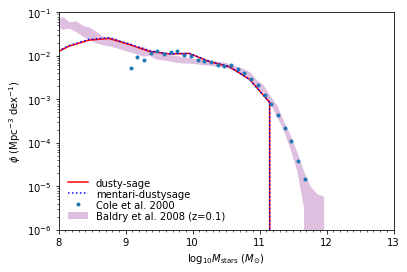

In [42]:
plt.figure()
ax = plt.subplot(111)

binwidth = 0.3
rec_frac=0.43
Hubble_h = 0.73

#w = np.where((G_history[0].StellarMass > 0) & (G_history[0].MetalsStellarMass > 0))[0]
#mass = np.log10(G_history[0].StellarMass[w] * 1.e10 / Hubble_h)

w1 = np.where((G_history_dusty[0].StellarMass > 0.0)& (G_history_dusty[0].MetalsStellarMass > 0))[0]
mass1 = np.log10(G_history_dusty[0].StellarMass[w1] * 1.e10 / Hubble_h)

w2 = np.where((metals_dusty[:,63] > 0) & (mass_dusty[:,63] / Hubble_h > 0))[0]
mass2 = np.log10(mass_dusty[:,63][w2] / Hubble_h)

#w3 = np.where(Mass[:,63] > 0)[0]
#mass3 = np.log10(Mass[:,63][w3])


#w3 = np.where((metals_sage[:,63] > 0) & (mass_sage[:,63] / Hubble_h > 0))[0]
#mass3 = np.log10(mass_sage[:,63][w3] / Hubble_h)

#c_mass = np.log10(MassHist_old[0]*MetalHist_old[0] * (1. - rec_frac) / Hubble_h) #final computed mass #final computed mass

mi = np.floor(min(mass1)) - 2
ma = np.floor(max(mass1)) + 2
ma = 14
NB = int((ma - mi) / binwidth)

#(counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)
(counts1, binedges1) = np.histogram(mass1, range=(mi, ma), bins=NB)
(counts2, binedges2) = np.histogram(mass2, range=(mi, ma), bins=NB)
#(counts3, binedges3) = np.histogram(mass3, range=(mi, ma), bins=NB)

# Set the x-axis values to be the centre of the bins
#xaxeshisto = binedges[:-1] + 0.5 * binwidth
xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
xaxeshisto2 = binedges2[:-1] + 0.5 * binwidth
#xaxeshisto3 = binedges3[:-1] + 0.5 * binwidth

#plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', label='sage')
#plt.plot(xaxeshisto3, counts3 / (BoxSize/Hubble_h)**3 / binwidth, 'g:', label='mentari-tree')
plt.plot(xaxeshisto1, counts1/ (BoxSize/Hubble_h)**3 / binwidth, 'r-', label='dusty-sage')
plt.plot(xaxeshisto2, counts2/ (BoxSize/Hubble_h)**3 / binwidth, 'b:', label='mentari-dustysage')

# Baldry+ 2008 modified data used for the MCMC fitting
Baldry = np.array([
            [7.05, 1.3531e-01, 6.0741e-02],
            [7.15, 1.3474e-01, 6.0109e-02],
            [7.25, 2.0971e-01, 7.7965e-02],
            [7.35, 1.7161e-01, 3.1841e-02],
            [7.45, 2.1648e-01, 5.7832e-02],
            [7.55, 2.1645e-01, 3.9988e-02],
            [7.65, 2.0837e-01, 4.8713e-02],
            [7.75, 2.0402e-01, 7.0061e-02],
            [7.85, 1.5536e-01, 3.9182e-02],
            [7.95, 1.5232e-01, 2.6824e-02],
            [8.05, 1.5067e-01, 4.8824e-02],
            [8.15, 1.3032e-01, 2.1892e-02],
            [8.25, 1.2545e-01, 3.5526e-02],
            [8.35, 9.8472e-02, 2.7181e-02],
            [8.45, 8.7194e-02, 2.8345e-02],
            [8.55, 7.0758e-02, 2.0808e-02],
            [8.65, 5.8190e-02, 1.3359e-02],
            [8.75, 5.6057e-02, 1.3512e-02],
            [8.85, 5.1380e-02, 1.2815e-02],
            [8.95, 4.4206e-02, 9.6866e-03],
            [9.05, 4.1149e-02, 1.0169e-02],
            [9.15, 3.4959e-02, 6.7898e-03],
            [9.25, 3.3111e-02, 8.3704e-03],
            [9.35, 3.0138e-02, 4.7741e-03],
            [9.45, 2.6692e-02, 5.5029e-03],
            [9.55, 2.4656e-02, 4.4359e-03],
            [9.65, 2.2885e-02, 3.7915e-03],
            [9.75, 2.1849e-02, 3.9812e-03],
            [9.85, 2.0383e-02, 3.2930e-03],
            [9.95, 1.9929e-02, 2.9370e-03],
            [10.05, 1.8865e-02, 2.4624e-03],
            [10.15, 1.8136e-02, 2.5208e-03],
            [10.25, 1.7657e-02, 2.4217e-03],
            [10.35, 1.6616e-02, 2.2784e-03],
            [10.45, 1.6114e-02, 2.1783e-03],
            [10.55, 1.4366e-02, 1.8819e-03],
            [10.65, 1.2588e-02, 1.8249e-03],
            [10.75, 1.1372e-02, 1.4436e-03],
            [10.85, 9.1213e-03, 1.5816e-03],
            [10.95, 6.1125e-03, 9.6735e-04],
            [11.05, 4.3923e-03, 9.6254e-04],
            [11.15, 2.5463e-03, 5.0038e-04],
            [11.25, 1.4298e-03, 4.2816e-04],
            [11.35, 6.4867e-04, 1.6439e-04],
            [11.45, 2.8294e-04, 9.9799e-05],
            [11.55, 1.0617e-04, 4.9085e-05],
            [11.65, 3.2702e-05, 2.4546e-05],
            [11.75, 1.2571e-05, 1.2571e-05],
            [11.85, 8.4589e-06, 8.4589e-06],
            [11.95, 7.4764e-06, 7.4764e-06],
            ], dtype=np.float32)

Baldry_xval = np.log10(10 ** Baldry[:, 0]  /Hubble_h/Hubble_h)
Baldry_xval = Baldry_xval - 0.26  # convert back to Chabrier IMF

Baldry_yvalU = (Baldry[:, 1]+Baldry[:, 2]) * Hubble_h*Hubble_h*Hubble_h
Baldry_yvalL = (Baldry[:, 1]-Baldry[:, 2]) * Hubble_h*Hubble_h*Hubble_h

plt.fill_between(Baldry_xval, Baldry_yvalU, Baldry_yvalL, facecolor='purple', alpha=0.25, label='Baldry et al. 2008 (z=0.1)')

M_cole = np.array([9.06, 9.16, 9.26, 9.36, 9.46, 9.56, 9.66, 9.76, 9.86, 9.96, 10.06, 10.16, 10.26, 10.36, 10.46, 10.56, 10.66, 10.76, 10.86, 10.96, 11.06, 11.16, 11.26, 11.36, 11.46, 11.56, 11.66])
Phi_cole = np.array([1.37e-2, 2.41e-2, 2.06e-2, 3.01e-2, 3.25e-2, 2.87e-2, 3.10e-2, 3.30e-2, 2.67e-2, 2.51e-2, 2.03e-2, 1.93e-2, 1.86e-2, 1.62e-2, 1.49e-2, 1.61e-2, 1.30e-2, 1.06e-2, 7.40e-3, 5.5e-3, 3.29e-3, 2.02e-3, 1.13e-3, 5.56e-4, 2.90e-4, 9.87e-5, 3.73e-5])
Cole_xval = np.log10(10 ** M_cole / Hubble_h/Hubble_h)
Cole_xval = Cole_xval - 0.26 #convert to Chabrier IMF

Cole_yval = Phi_cole * Hubble_h*Hubble_h*Hubble_h
plt.plot(Cole_xval, Cole_yval, '.', label='Cole et al. 2000')

plt.yscale('log', nonposy='clip')
plt.axis([8.0, 13.0, 1.0e-6, 1.0e-1])

# Set the x-axis minor ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))

plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$')  # and the x-axis labels

leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')

#plt.savefig('SMF_z0.png')
plt.show()

## Compute attenuation parameters

In [43]:
#w = np.where((mass_dusty[:,snap_limit] > 0) & (dust[:,snap_limit] > 0))[0]
w = np.where(mass_dusty[:,snap_limit] > 0)[0]
Mass = mass_dusty[w] / Hubble_h 
Metals = metals_dusty[w]

Dust = dust[w,snap_limit] / Hubble_h
Gas = gas[w,snap_limit] / Hubble_h
Rad = rad[w,snap_limit] / Hubble_h

#Sigma_eta_ISM, eta_ISM[w] = compute_etaISM_Trayford(Dust, Gas, Rad)
tau_BC, eta_BC, tau_ISM, eta_ISM = compute_attenuation_parameters (1, Dust, Gas, Rad)
'''
eta_BC = [-0.7] * len(Dust)
eta_ISM_v2 = [-1.3] * len(Dust)
Sigma_BC, tau_head_BC = compute_tauBC_Trayford(Dust, Gas, Rad)
Sigma_tau_ISM, tau_head_ISM = compute_tauISM_Trayford(Dust, Gas, Rad)
Sigma_eta_ISM, eta_ISM = compute_etaISM_Trayford(Dust, Gas, Rad)

Sigma_ISM_v2, tau_ISM_v2 = compute_tauISM_Somerville (Dust, Rad)
Sigma_BC_v2, tau_BC_v2 = compute_tauBC_Somerville (Dust, Rad)
'''

'\neta_BC = [-0.7] * len(Dust)\neta_ISM_v2 = [-1.3] * len(Dust)\nSigma_BC, tau_head_BC = compute_tauBC_Trayford(Dust, Gas, Rad)\nSigma_tau_ISM, tau_head_ISM = compute_tauISM_Trayford(Dust, Gas, Rad)\nSigma_eta_ISM, eta_ISM = compute_etaISM_Trayford(Dust, Gas, Rad)\n\nSigma_ISM_v2, tau_ISM_v2 = compute_tauISM_Somerville (Dust, Rad)\nSigma_BC_v2, tau_BC_v2 = compute_tauBC_Somerville (Dust, Rad)\n'

In [ ]:
w = np.where((mass_dusty[:,snap_limit] > 0))[0]
Mass = mass_dusty[w] / Hubble_h 
Metals = metals_dusty[w]

DustMass = dust[w,snap_limit] / Hubble_h
GasMass = gas[w,snap_limit] / Hubble_h
Radius = rad[w,snap_limit] / Hubble_h

eta_BC = [-0.7] * len(DustMass)
eta_ISM = [-1.3] * len(DustMass)
tau_BC = np.zeros(len(DustMass))
tau_ISM = np.zeros(len(DustMass))

w = np.where(DustMass > 0)[0]
print(w)
'''
if prescription_choice == 0:
    Sigma_BC, tau_BC[w] = compute_tauBC_Trayford(DustMass[w], GasMass[w], Radius[w])
    Sigma_tau_ISM, tau_ISM[w] = compute_tauISM_Trayford(DustMass[w], GasMass[w], Radius[w])
    Sigma_eta_ISM, eta_ISM[w] = compute_etaISM_Trayford(DustMass[w], GasMass[w], Radius[w])

elif prescription_choice == 1:
'''
Sigma_ISM, tau_ISM[w] = compute_tauISM_Somerville (DustMass[w], Radius[w])
Sigma_BC, tau_BC[w] = compute_tauBC_Somerville (DustMass[w], Radius[w])

## Plot the parameters

In [ ]:
#Data from Trayford+ 19
#Sigma_dust vs tau ISM
Sigma_dust_tau = [4.088, 4.351, 4.579, 4.823, 5.057, 5.292, 5.528, 5.765, 6.001, 6.234, 6.470, 6.704, 6.941, 7.177, 7.416]
tau_head_Trayford = [0.031, 0.059, 0.078, 0.129, 0.203, 0.308, 0.467, 0.647, 0.838, 1.065, 1.235, 1.475, 1.571, 1.645, 1.806]

Sigma_dust_eta = [4.116, 4.354, 4.588, 4.822, 5.061, 5.293, 5.533, 5.763, 6.003, 6.236, 6.469, 6.706, 6.943, 7.181, 7.411]
eta_ISM_Trayford = [-1.379, -1.357, -1.334, -1.243, -1.170, -1.062, -0.922, -0.778, -0.668, -0.570, -0.506, -0.453, -0.381, -0.318, -0.307]

plt.plot(Sigma_dust_tau, tau_head_Trayford, '-', label=r'Trayford+ 19 ($\tau_\mathrm{ISM}$)')
plt.plot(Sigma_tau_ISM, tau_head_ISM, '.', markersize=6, label=r'$\tau_\mathrm{ISM}\ (r = 0.4 r_s)$')
plt.plot(Sigma_BC, tau_head_BC, '.', markersize=1, label=r'$\tau_\mathrm{BC}\ (r = 0.4 r_s)$')

plt.plot(np.log10(Sigma_ISM_v2 * 1e6), tau_ISM_v2, '.', markersize=1, label=r'Somerville formula ($\tau_\mathrm{ISM}$)')
plt.plot(np.log10(Sigma_BC_v2 * 1e6), tau_BC_v2, '.', markersize=1, label=r'Somerville formula ($\tau_\mathrm{BC}$)')
plt.xlim(2, 8)
plt.ylim(0, 3)
plt.legend(loc=0)
plt.xlabel(r'$\log_{10} \Sigma_\mathrm{dust} (\mathrm{M_\odot} \mathrm{kpc}^{-2})$')
plt.ylabel(r'$\tau$')
#plt.savefig('plots/tau_mini_somerville.png')

In [ ]:
plt.plot(Sigma_dust_tau, eta_ISM_Trayford, '.-', label='Trayford+ 19 ($\eta_\mathrm{ISM}$)')
plt.plot(Sigma_eta_ISM, eta_ISM, '.', label=r'$\eta_\mathrm{ISM}\ (r = 0.4 r_s)$')

plt.axhline(-0.7, c='green', lw=0.8, label=r'$\eta_\mathrm{BC}$')
plt.xlabel(r'$\log_{10} \Sigma_\mathrm{dust} (\mathrm{M_\odot} \mathrm{kpc}^{-2})$')
plt.ylabel(r'$\eta$')

plt.legend(loc=0)
plt.xlim(2, 8)
#plt.savefig('plots/eta_03.png')

## Generate spectra (including attenuation)

In [44]:
Age = np.asarray([0.0124, 0.0246, 0.0491, 0.1037, 0.1871, 0.2120, 0.2399, 0.2709, 0.3054, 0.3438, 0.3864, 0.4335, 0.4856, 0.5430, 0.6062, 0.6756, 0.7517, 0.8349, 0.9259, 1.0249, 1.1327, 1.2496, 1.3763, 1.5131, 1.6606, 1.8192, 1.9895, 2.1717, 2.3662, 2.5734, 2.7934, 3.0265, 3.2726, 3.5318, 3.8038, 4.0886, 4.3856, 4.6944, 5.0144, 5.3488, 5.6849, 6.0337, 6.3901, 6.7531, 7.1215, 7.4940, 7.8694, 8.2464, 8.6238, 9.0004, 9.3750, 9.7463, 10.1133, 10.4750, 10.8303, 11.1783, 11.5181, 11.8490, 12.1702, 12.4811, 12.7810, 13.0695, 13.3459, 13.6098])
lookbacktime = sorted((np.array([13.6098]*len(Age)) - Age) * 1.e9)
time_BC = 10**7
#tau_head_ISM = 0.65
#tau_head_ISM_2 = 0.5
#tau_head_BC = 1.0
#eta_BC = -0.7
#eta_BC = [-0.7, -0.7]
#eta_BC_2 = -1.3
#eta_ISM = -1.4

In [ ]:
wavelength_s, spectra_s, spectra_dusty_s = generate_SED(1, Age, Mass, Metals, 
             tau_BC_v2, tau_ISM_v2, eta_BC, eta_ISM_v2, time_BC)

In [45]:
wavelength, spectra, spectra_dusty = generate_SED(1, Age, Mass, Metals, 
             tau_BC, tau_ISM, eta_BC, eta_ISM, time_BC)

0 %.....................10 %.....................20 %.....................30 %.....................40 %.....................50 %.....................60 %.....................70 %.....................80 %.....................90 %.....................

In [ ]:
Dale_template = np.loadtxt('files/spectra.0.00AGN.dat', unpack=True)
lambda_IR = Dale_template[0] * 1e4 #convert from micron to Angstrom

Ldust = (spectra - spectra_dusty)
w = np.where(wavelength < 912)[0]
idx_912 = w[-1]

all_wave = np.unique(np.concatenate((wavelength, lambda_IR)))
all_wave.sort(kind='mergesort')
UVIR = np.zeros((len(Ldust), len(all_wave)))

for i in range(len(Ldust)):
    LIR_mentari = trapz(Ldust[i][idx_912:-1], wavelength[idx_912:-1])

    idx = determine_idx_Marcillac(LIR_mentari)
    spectra_IR = 10 ** Dale_template[idx[0]+1]

    LIR_dale = trapz(spectra_IR, lambda_IR)
    scaling = LIR_mentari / LIR_dale
    spectra_IR_dale = spectra_IR * scaling 

    wa = np.where((all_wave < wavelength[-1]) | (all_wave == wavelength[-1]))[0]
    UVIR[i][wa] += np.interp(all_wave[wa], wavelength, spectra_dusty[i])

    we = np.where((all_wave > lambda_IR[0]) | (all_wave == lambda_IR[0]))[0]
    UVIR[i][we] += np.interp(all_wave[we], lambda_IR, spectra_IR_dale)

plt.plot(all_wave, UVIR[i])
plt.plot(wavelength, spectra_dusty[i])
plt.yscale('log')
plt.xscale('log')


In [ ]:
wavelength_cf, spectra_cf, spectra_dusty_cf = generate_SED(1, Age, Mass, Metals, 
             tau_head_BC, tau_head_ISM, eta_BC, eta_ISM, time_BC)

In [ ]:
%lprun -f generate_SED generate_SED(1, Age, Mass, Metals, tau_head_BC, tau_head_ISM, eta_BC, eta_ISM, time_BC)

## Computing H-alpha luminosity (Orsi+ 2012)

In [ ]:
w = np.where(wavelength < 912)[0]
idx_912 = w[-1]
delta = wavelength[1:idx_912] - wavelength[0:idx_912-1]

Lsun2cgs = 3.846e33
h = 6.6261e-27 #cgs
c = 2.99e10 #cgs
L_Ha = []

for i in range(len(spectra_dusty)):
    int_Q = sum(wavelength[1:idx_912] * spectra_dusty[i][1:idx_912] * delta)
    Q = int_Q * Lsun2cgs / (h*c)
    L_ha = 1.37e-12 * Q
    L_Ha.append(np.log10(L_ha / Hubble_h / Hubble_h))

In [ ]:
mi = 40
ma = 50
binwidth = 0.3
NB = int((ma - mi) / binwidth)
volume = (BoxSize/Hubble_h)**3

plt.figure()
ax =plt.subplot(111)

counts, binedges = np.histogram(L_Ha, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, lw=1.0)
plt.yscale('log')

## Incorporating Dale+ 2014 IR template

In [47]:
wavelength_dale, spectra_dale = add_IR_Dale(wavelength, spectra, spectra_dusty)

/Users/dtriani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


In [46]:
wavelength_s, spectra_s = combine_Dale_SUNRISE(Dust, wavelength, spectra, spectra_dusty)

/Users/dtriani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


In [ ]:
len(Dust), len(spectra_s)

## Random checking for IR spectra

In [ ]:
w = np.where((Mass[:,63] / Hubble_h > 5.65e10) & (Mass[:,63] / Hubble_h < 6e10) & (Dust > 0))[0]
a=w[6]
alpha_SF, log_fnu_SF = np.loadtxt('files/alpha.dat', unpack=True)
Dale_template = np.loadtxt('files/spectra.0.00AGN.dat', unpack=True)
lambda_IR = Dale_template[0] * 1e4 #convert from micron to Angstrom

Ldust = (spectra - spectra_dusty)
w = np.where(wavelength < 912)[0]
idx_912 = w[-1]

all_wave = np.unique(np.concatenate((wavelength, lambda_IR)))
all_wave.sort(kind='mergesort')
UVIR = np.zeros((len(Ldust), len(all_wave)))

LIR_mentari = trapz(Ldust[a][idx_912:-1], wavelength[idx_912:-1])

log_fnu = 0.128 * np.log10(LIR_mentari) - 1.611
delta_fnu = abs(log_fnu_SF - log_fnu)
idx = np.where(delta_fnu==min(delta_fnu))[0]
spectra_IR = 10 ** Dale_template[idx[0]+1]
LIR_dale = trapz(spectra_IR, lambda_IR)
scaling = LIR_mentari / LIR_dale
spectra_IR_dale = spectra_IR * scaling 

new_spectra = np.interp(all_wave, wavelength, spectra_dusty[a])
w = np.where(all_wave > lambda_IR[0])[0]
new_IR = np.interp(all_wave[w], lambda_IR, spectra_IR_dale)
new_spectra[w] = new_spectra[w] + new_IR

lam, sed = find_template_SUNRISE(np.log10(LIR_mentari), np.log10(Dust[a]))
w = np.where(all_wave < lam[0]*1e4)
all_wave_b = np.unique(np.concatenate((all_wave[w], lam*1e4)))
all_wave_b.sort(kind='mergesort')
print(min(lam*1e4), max(lam*1e4))

new_spectra_b = np.zeros(len(all_wave_b))
w = np.where((all_wave_b < lam[0]*1e4) | (all_wave_b == lam[0]*1e4))
new_spectra_b[w] = np.interp(all_wave_b[w], all_wave, new_spectra*all_wave)
'''
new_spectra_b = np.interp(all_wave_b, wavelength, spectra_dusty[a]*wavelength)
w = np.where(((all_wave_b < lam[0]*1e4) | (all_wave_b == lam[0]*1e4)) & (all_wave_b > lambda_IR[0]))[0]
MIR_b = np.interp(all_wave_b[w], lambda_IR, spectra_IR_dale*lambda_IR)
new_spectra_b[w] = new_spectra_b[w] + MIR_b
'''
w = np.where(all_wave_b > lam[0]*1e4)[0]
#new_IR_b = np.interp(all_wave_b[w], lam*1e4, sed)
#new_spectra_b[w] = new_spectra_b[w] + new_IR_b 
new_spectra_b[w] = np.interp(all_wave_b[w], lam*1e4, sed)

plt.plot(all_wave_b, new_spectra_b, label="Safarzadeh+15")
plt.plot(all_wave, new_spectra*all_wave, label='Dale+14')
#plt.plot(all_wave, all_spec*all_wave)
#plt.plot(all_wave_b, all_spec_b)
plt.plot(wave, spec, lw=0.5, label= ('NGC 5055 (Brown et al. 2014)'))

plt.ylim(1e7, 1e11)
plt.xlim(1200, 1e7)
plt.yscale('log')
plt.xscale('log')
plt.legend(loc=0)


plt.xlabel(r'$\lambda\ (\AA) $')
plt.ylabel(r'log $\lambda L_{\lambda} (L_{\odot})$')

#plt.savefig('SED-UVIR.png')


In [ ]:
print(full)

In [ ]:
print(len(full_spectra_a[0]))

In [ ]:
plt.plot(lambda_IR, LIR[2] * lambda_IR)
plt.xscale('log')
plt.yscale('log')

In [ ]:
spectra_IR_v2 = 10 ** spectra_IR


print(LIR[0]/L_TIR)

In [ ]:
plt.plot(np.log10(Dust), np.log10(LIR), '.')
plt.xlim(4, 9)
plt.ylim(5, 15)
plt.xlabel(r'log $M_\mathrm{dust} (M_{\odot})$')
plt.ylabel(r'log $\lambda L_{IR} (L_{\odot})$')
#plt.savefig('plots/LIR-Mdust.png')

In [ ]:
plt.plot(np.log10(Dust), alpha, '.')
plt.xlim(4, 9)
plt.ylim(0, 5)
plt.xlabel(r'log $M_\mathrm{dust} (M_{\odot})$')
plt.ylabel(r'$ \alpha_\mathrm{SF}$')
plt.savefig('plots/alpha-Mdust.png')

In [ ]:
plt.plot(np.log10(LIR), alpha_list, '.')
plt.xlabel(r'log $\lambda L_{IR} (L_{\odot})$')

plt.axhline(1.5)
plt.axvline(11.6)
plt.axvline(9.5)
plt.axhline(3.05)

#plt.xlim(4, 9)
#plt.ylim(1, 8)
#plt.xlabel(r'log $M_\mathrm{dust} (M_{\odot})$')
#plt.ylabel(r'$ \alpha_\mathrm{SF}$')
#plt.savefig('plots/alpha-Mdust.png')

## Plotting full spectra

In [ ]:
Hubble_h = 0.73
print(len(Mass[0]))
w = np.where(Mass[:,63] == max(Mass[:,63]))[0]
MassHist = list(Mass[w])
#MetalHist = list(metals_dusty[w])

In [ ]:
#To plot the spectra:

ax = plt.subplot2grid((1,1), (0,0))
#divider = make_axes_locatable(ax)
#ax.plot(wavelength, np.log10(Spectra_arr[10] * np.array(wavelength)), lw=0.5, label='stellar')
#ax.plot(wavelength, np.log10(spectra_dusty[10] * np.array(wavelength)), lw=0.5, label='dusty')
#ax.plot(np.array(wavelength_old), spectra_old[0] * np.array(wavelength_old), lw=0.5, label='sage')
#plt.plot(lambda_IR, np.log10(LIR[10] * lambda_IR))
#plt.plot(all_wave, np.log10(UVIR[10] * all_wave))
plt.plot(full_wavelength, np.log10(Spectra_arr[1] * full_wavelength), '--')
plt.legend()

ax.set_xlabel(r'$\lambda\ (\AA) $')
ax.set_ylabel(r'log $\lambda L_{\lambda} (L_{\odot})$')
ax.set_xscale('log')
#ax.set_yscale('log')
#plt.savefig('SED-dusty.png')

In [ ]:
spiral = np.loadtxt('NGC_5055_spec.dat', unpack=True)
wave = spiral[0]
spec = spiral[1]
dl = 7.8 * 3.086e+24 #Mpc to cm
spec = spec*wave * (4*np.pi*dl**2) / 3.826e33 #ergs/s to Lsun

In [ ]:
stellarmass = G_history_dusty[0].StellarMass * 1e10 / Hubble_h
dustmass = G_history_dusty[0].ColdDust * 1e10 / Hubble_h
sfr = G_history_dusty[0].SfrDisk + G_history_dusty[0].SfrBulge

w = np.where((stellarmass > 5.65e10) & (stellarmass < 6e10) & (dustmass > 0))[0]
print(len(w), stellarmass[w[3]], dustmass[w[3]], sfr[w[3]])

w = np.where((Mass[:,63] / Hubble_h > 5.65e10) & (Mass[:,63] / Hubble_h < 6e10) & (Dust > 0))[0]
print(len(w), Mass[w[6],63] / Hubble_h, Dust[w[6]])
#To plot the spectra:
ax = plt.subplot2grid((1,1), (0,0))
#divider = make_axes_locatable(ax)
plt.plot(wave, spec, lw=1, label= ('NGC 5055 (Brown et al. 2014)'))
#ax.plot(np.array(wavelength), spectra[w[6]] * np.array(wavelength), lw=2, label='intrinsic')
#ax.plot(np.array(wavelength), spectra_dusty[w[1]] * np.array(wavelength), lw=0.5, label='dusty')
#ax.plot(np.array(all_wave), UVIR[w[6]] * all_wave,  lw=0.5, label='dusty')
ax.plot(np.array(full_wavelength), Spectra_arr[w[6]] * full_wavelength, '--', lw=0.5, label='attenuated')

#ax.plot(np.array(wavelength_sage), spectra_sage[0] * np.array(wavelength_sage), lw=0.5, label='sage')
#ax.plot(np.array(wavelength_old), spectra_old[0] * np.array(wavelength_old), lw=0.5, label='sage')
plt.ylim(1e7, 1e11)
plt.xlim(1200, 1e7)
plt.xscale('log')
plt.yscale('log')

plt.legend(loc=0)

ax.set_xlabel(r'$\lambda\ (\AA) $')
ax.set_ylabel(r'log $\lambda L_{\lambda} (L_{\odot})$')

#plt.savefig('SED-spiral.png')

In [ ]:
with h5py.File('mentari_test7.h5', 'a') as f:
    full_wavelength_a = np.array(f["Wavelength_UVIR"])
    full_spectra_a = np.array(f['Spectra_UVIR'])

In [49]:
print(wavelength_s)

[ 300768.03  346274.22  416969.29  481620.69  560562.56  672924.15
  811040.57 1001056.3  1191938.1  1380906.8  1670676.8  2063979.7
 2512247.1  3042150.3  3746751.7  4626296.1  5602947.   6669246.7
 8064783.7 ]


## Plotting UV - optical LF

In [ ]:
filter_list = ('TwoMass_Ks', 'Sdss_u', 'Sdss_g', 'Sdss_r', 'Sdss_i', 'Sdss_z')
z = 0

In [ ]:
mab_dusty = compute_mab(wavelength_dale, spectra_dale, filter_list, z)
mab_dusty_s = compute_mab(wavelength_s, spectra_s, filter_list, z)

In [ ]:
%lprun -f compute_mab compute_mab(full_wavelength, full_spectra, filter_list, z)

In [ ]:
mab_dusty_t = compute_mab(wavelength, spectra_dusty, filter_list, z)

In [ ]:
mab_nodust = compute_mab(wavelength, spectra, filter_list, z)

In [ ]:
mab_dusty_s = compute_mab(wavelength_s, spectra_dusty_s, filter_list, z)
mab_dusty_cf = compute_mab(wavelength_cf, spectra_dusty_cf, filter_list, z)

In [ ]:
hubble=0.73
label = ['Mu', 'Mg', 'Mr', 'Mi', 'Mz']
color = ('grey', 'black', 'blue', 'red', 'green', 'purple')
volume = (BoxSize/Hubble_h)**3

In [ ]:
mi = -30.0
ma = -15.0
binwidth = 0.3
NB = int((ma - mi) / binwidth)
#M = np.arange(mi, ma, 0.01)

plt.figure()
ax =plt.subplot(111)

# Cole et al. 2001 K band 2dFGRS LF
Cole_Phi = np.array([3.1315561E-03, 8.2625253E-03, 0.0000000E+00, 4.6483092E-03, 5.7576019E-03, 9.1649834E-03, 1.1232893E-02,
            1.0536440E-02, 8.5763102E-03, 8.8181989E-03, 6.9448259E-03, 6.0896124E-03, 9.2596142E-03, 6.9631678E-03,
            7.2867479E-03, 6.9923755E-03, 5.9844730E-03, 5.9305103E-03, 5.3865365E-03, 5.8525647E-03, 5.2373926E-03,
            4.9635037E-03, 4.1801766E-03, 2.7171015E-03, 1.8800517E-03, 1.2136410E-03, 6.5419916E-04, 3.4594961E-04,
            1.4771589E-04, 5.5521199E-05, 2.1283222E-05, 9.4211919E-06, 1.0871951E-06, 2.7923562E-07])
Cole_PhiErr = np.array([3.6377162E-03, 6.6833422E-03, 1.0000000E-10, 4.0996978E-03, 4.3155681E-03, 5.6722397E-03, 6.4211683E-03,
            5.7120644E-03, 4.6346937E-03, 3.8633577E-03, 2.4383855E-03, 1.6279118E-03, 1.6941463E-03, 1.1781409E-03,
            9.7785855E-04, 7.9027453E-04, 6.0649612E-04, 5.1598746E-04, 4.2267537E-04, 3.7395130E-04, 2.8177485E-04,
            2.1805518E-04, 1.6829016E-04, 1.1366483E-04, 8.1871600E-05, 5.7472309E-05, 3.6554517E-05, 2.3141622E-05,
            1.2801432E-05, 6.5092854E-06, 3.3540452E-06, 1.9559407E-06, 5.6035748E-07, 2.8150106E-07])
Cole_Mag = np.array([-18.00000, -18.25000, -18.50000, -18.75000, -19.00000, -19.25000, -19.50000, -19.75000, -20.00000,
            -20.25000, -20.50000, -20.75000, -21.00000, -21.25000, -21.50000, -21.75000, -22.00000, -22.25000,
            -22.50000, -22.75000, -23.00000, -23.25000, -23.50000, -23.75000, -24.00000, -24.25000, -24.50000,
            -24.75000, -25.00000, -25.25000, -25.50000, -25.75000, -26.00000, -26.25000])

# Huang et al. 2003 K band Hawaii+AAO LF
Huang_Phi = np.array([0.0347093, 0.0252148, 0.0437980, 0.0250516, 0.00939655, 0.0193473, 0.0162743, 0.0142267, 0.0174460,
            0.0100971, 0.0136507, 0.00994688, 0.00655286, 0.00528234, 0.00310017, 0.00157789, 0.000721131,
            0.000272634, 8.33409e-05, 2.12150e-05, 3.97432e-06, 5.07697e-06, 5.42939e-07])
Huang_PhiErr = np.array([ 0.0249755, 0.0181685, 0.0161526, 0.0105895, 0.00479689, 0.00525068, 0.00428192, 0.00308970, 0.00248676,
            0.00166458, 0.00166691, 0.00106289, 0.000704721, 0.000527429, 0.000340814, 0.000170548, 8.25681e-05,
            3.81529e-05, 1.50279e-05, 6.16614e-06, 2.34362e-06, 1.98971e-06, 5.54946e-07])
Huang_Mag = np.array([-19.8000, -20.1000, -20.4000, -20.7000, -21.0000, -21.3000, -21.6000, -21.9000, -22.2000, -22.5000,
            -22.8000, -23.1000, -23.4000, -23.7000, -24.0000, -24.3000, -24.6000, -24.9000, -25.2000,
            -25.5000, -25.8000, -26.1000, -26.4000])

# Finally plot the observational data
Cole_xval = Cole_Mag + 0.65 #convert to Chabrier IMF
Huang_xval = Huang_Mag + 0.65 #convert to Chabrier IMF
plt.errorbar(Cole_xval+5.0*np.log10(Hubble_h), Cole_Phi*Hubble_h*Hubble_h*Hubble_h, yerr=Cole_PhiErr*Hubble_h*Hubble_h*Hubble_h, color='m', lw=1.0, marker='o', ls='none', label='Cole et al. 2001')
plt.errorbar(Huang_xval+5.0*np.log10(Hubble_h), Huang_Phi*Hubble_h*Hubble_h*Hubble_h, yerr=Huang_PhiErr*Hubble_h*Hubble_h*Hubble_h, color='g', lw=1.0, marker='o', ls='none', label='Huang et al. 2003')

twomass_k = [0]
sdss_ug = [1, 2]
sdss_r = [3]
sdss_i = [4]
sdss_z = [5]
sdss_iz=[4, 5]
sdss =[1,2,3,4,5]
'''
counts, binedges = np.histogram(mab_nodust[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, c=color[0], lw=1.0, label='no-dust')
'''
counts, binedges = np.histogram(mab_dusty[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, '--', c=color[0], lw=1.0, label='Trayford+ 19')

counts, binedges = np.histogram(mab_dusty_s[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, '-.', c='b', lw=1.0, label='Somerville+ 12')
'''
counts, binedges = np.histogram(mab_dusty_cf[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, ':', c='r', lw=1.0, label='CF00')

counts, binedges = np.histogram(mab_dusty_4[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, ':', c='r', lw=1.0, label=r'$\eta_\mathrm{BC}=-1.3$')

counts, binedges = np.histogram(mab_dusty_5[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, '-.', c='b', lw=1.0, label=r'$\eta_\mathrm{ISM}=-1.3$')


counts, binedges = np.histogram(mab_sage[0]-1.85, range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ volume / binwidth, '--', c=color[0], lw=2.0, label='sage-no-dust')
'''
plt.yscale('log', nonposy='clip')
plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{mag}^{-1})$')  # Set the y...
plt.xlabel(r'$M_\mathrm{K}$')
plt.ylim(4e-7, 4e-2)
plt.xlim(-19.5, -27.5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
#plt.savefig('plots/k-mini.png')
plt.show()

In [ ]:
mi = -30.0
ma = -15.0
binwidth = 0.3
NB = int((ma - mi) / binwidth)
M = np.arange(mi, ma, 0.1)
label = ['Mk', 'Mu', 'Mg', 'Mr', 'Mi', 'Mz']
# Observations from Kelvin et al. 2013
Mstar = [0, -18.53, -20.28, -20.90, -21.45, -21.78]
alpha1 = [0, -0.91, -1.29, -1.13, -1.35, -1.46]
phistar1 = [0, 0.00964, 0.00351, 0.00451, 0.00220, 0.0014]
alpha2 = [0, 1.25, 0.06, 0.53, -0.09, -0.26]
phistar2 = [0, 0.00146, 0.00488, 0.00301, 0.00487, 0.00505]

plt.figure(figsize=(16,8))
row = 2
col = 3
for i in range(1, 6):
    ax =plt.subplot(row, col, i)
    '''
    counts, binedges = np.histogram(mab_nodust[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ volume / binwidth, c=color[i], lw=1.0, label='no-dust')
    '''
    counts, binedges = np.histogram(mab_dusty[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ volume / binwidth, '--', c=color[i], lw=1.0, label='Trayford+ 19')
    
    counts, binedges = np.histogram(mab_dusty_s[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ volume / binwidth, '-.', c=color[i], lw=1.0, label='Somerville+ 12')
    '''
    counts, binedges = np.histogram(mab_dusty_cf[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ volume / binwidth, ':', c=color[i],lw=1.0, label='CF00')
    '''
    #plot Kelvin+ 13 dataset
    M_plot = M + 0.65 #convert back to Chabrier IMF
    xval = 10.0 ** (0.4*(Mstar[i]-M)) 
    yval = 0.4 * np.log(10.0) * (phistar1[i] * xval ** (alpha1[i]+1) + phistar2[i] * xval ** (alpha2[i]+1)) * np.exp(-xval)                
    plt.plot(M_plot, yval, '--', c=color[i], lw=0.5, label='Kelvin+ 13')

    plt.yscale('log', nonposy='clip')
    plt.ylim(2e-7, 2e-2)
    plt.xlim(-17.1, -24.9)
    ax.tick_params(axis='both', which='both', direction='in')
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
    plt.xlabel(label[i])


leg = plt.legend(loc=0, numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
#plt.savefig('plots/sdss-mini.png')
#plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Plotting IR LF

In [ ]:
IR_filter = ('IRAC_1','IRAC_4', 'MIPS_24um', 'MIPS_70um','PACS_160um', 'SPIRE_250um', 'SPIRE_500um')
z=0
mab_IR = compute_mab(wavelength_dale, spectra_dale, IR_filter, z)
mab_IR_s = compute_mab(wavelength_s, spectra_s, IR_filter, z)
#mab_IR_s = compute_mab(full_wavelength_s, full_spectra_s, IR_filter, z)
#mab_IR_cf = compute_mab(full_wavelength_cf, full_spectra_cf, IR_filter, z)
#mab_IR = compute_mab(all_wave, UVIR, IR_filter, z)

In [ ]:
w = np.where((mab_IR_s[5] > -27) & (mab_IR_s[5] < -26.5))[0]


print(len(w))

mi = -30.0
ma = -20.0
binwidth = 0.25
NB = int((ma - mi) / binwidth)

counts1, binedges1 = np.histogram(mab_IR_s[5], range=(mi, ma), bins=NB)
print(sum(counts1))
xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
print(counts1, xaxeshisto1)


plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, '--', lw=1.5, label='Somerville+ 12')

plt.yscale('log', nonposy='clip')
plt.ylim(2e-5, 2e-2)
plt.xlim(-30.5, -20.5)
ax.tick_params(axis='both', which='both', direction='in')


In [ ]:
w = np.where((mab_IR[5] > -28.17622848) & (mab_IR[5] < -27.96733838))[0]
print(w)

In [50]:
IR_filter_d = ('MIPS_70um','PACS_160um', 'SPIRE_250um', 'SPIRE_500um')
z=0
mab_IR = compute_mab(wavelength_dale, spectra_dale, IR_filter_d, z)
mab_IR_s = compute_mab(wavelength_s, spectra_s, IR_filter_d, z)


/Users/dtriani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10


In [136]:
lam, sed = find_template_SUNRISE(11.0, 7.4)
mab = compute_mab(lam*1e4, sed / (lam * 1e4), IR_filter_d, z)
mab[2]

-26.115420648607945

In [ ]:
plt.plot(np.array(full_wavelength), full_spectra[w[6]] * full_wavelength,  lw=0.5, label='dusty')
plt.ylim(1e8, 1e11)
plt.xlim(1200, 1e7)

F = read_filters()
for i in range(len(IR_filter)):
    filters_wave = eval('F.' + IR_filter[i] + '_wave')
    filters = eval('F.' + IR_filter[i])
    plt.plot(filters_wave, filters*2e10, label=IR_filter[i])

    
plt.xscale('log')
plt.yscale('log')

plt.legend(loc='upper left')

plt.xlabel(r'$\lambda\ (\AA) $')
plt.ylabel(r'log $\lambda L_{\lambda} (L_{\odot})$')
#plt.savefig('plots/IRfilters.png')

In [ ]:
lowlim_list = [-25.3, -25.3, -23.8]
uplim_list = [-29, -29, -28]

row = 4
col = 2
fig, axes = plt.subplots(row, col, sharey=True, figsize=(9,12))

mi = -30.0
ma = -20.0
binwidth = 0.3
NB = int((ma - mi) / binwidth)

for i in range(0, 7):
    ax = plt.subplot(row, col, i+1)
    counts1, binedges1 = np.histogram(mab_IR[i], range=(mi, ma), bins=NB)
    xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, 'o', lw=1.5, label=IR_filter[i] + 'Trayford+09')
    
    counts1, binedges1 = np.histogram(mab_IR_s[i], range=(mi, ma), bins=NB)
    xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
    print(i, counts1, xaxeshisto1)
    
    plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, '.', lw=1.5, label='Somerville+ 12')
    '''
    counts1, binedges1 = np.histogram(mab_IR_cf[i], range=(mi, ma), bins=NB)
    xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, ':', lw=1.5, label='CF00')
    '''
    plt.yscale('log', nonposy='clip')
    plt.ylim(2e-5, 2e-2)
    plt.xlim(-30.5, -20.5)
    ax.tick_params(axis='both', which='both', direction='in')
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
'''    

plt.subplot(421)
Dai_mag = [-21.852, -21.591, -21.348, -21.087, -20.850, -20.619, -20.351, -20.157,
          -19.886, -19.596, -19.347, -19.090, -18.855, -18.602, -18.364, -18.114,
          -17.854, -17.598, -17.351, -17.127, -16.833, -16.600, -16.344, -16.101, 
          -15.862, -15.566]
Dai_phi = 10 ** np.array([-3.527, -3.028, -2.935, -2.674, -2.548, -2.389, -2.300, -2.197, -2.148, -2.046,
          -2.032, -1.974, -1.944, -1.957, -1.718, -1.832, -1.766, -1.825, -1.830, -1.469,
          -1.198, -1.408, -1.574, -1.701, -1.020, -1.027])
plt.errorbar(Dai_mag+5.0*np.log10(Hubble_h), Dai_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Dai et al. 2009')
plt.legend(loc='upper left')
plt.xlim(-26.5, -16.5)

plt.subplot(422).set_yticklabels([])
plt.subplot(422).set_ylabel('')
Dai_mag = [-23.768, -23.495, -23.266, -22.995, -22.734, -22.466, -22.265, -21.976,
          -21.790, -21.519, -21.264, -20.966, -20.752, -20.479, -20.274, -19.986,
          -19.718, -19.493, -19.220, -18.996, -18.749, -18.491, -18.247, -18.002,
          -17.745, -17.491, -17.265, -16.762, -16.013, -16.985]
Dai_phi = 10 ** np.array([-4.235, -3.838, -3.500, -3.339, -3.038, -2.803, -2.712,
                         -2.598, -2.523, -2.448, -2.388, -2.300, -2.253, -2.237,
                          -2.084, -2.092, -2.068, -1.921, -2.007, -1.799, -1.784,
                         -1.767, -1.686, -1.422, -1.371, -1.596, -1.120, -1.203,
                         -1.566, -1.863])
plt.errorbar(Dai_mag+5.0*np.log10(Hubble_h), Dai_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Dai et al. 2009')
plt.legend(loc='upper left')
plt.xlim(-26.5, -16.5)

plt.subplot(423)
plt.legend(loc='upper left')
plt.xlim(-26.5, -20.5)

plt.subplot(424).set_yticklabels([])
plt.subplot(424).set_ylabel('')
plt.legend(loc='upper left')

plt.subplot(425)
#Marchetti_mag, Marchetti_phi = np.loadtxt('files/Marchetti_PACS160.dat', usecols=(0,1), unpack=True)
Marchetti_mag = [-27.811, -27.373, -26.953, -26.573, -26.031, -25.686, -25.271, -24.844,
                -24.413, -23.998, -23.596, -23.121, -22.819, -22.347]
Marchetti_phi = 10 ** np.array([-4.123, -3.558, -3.032, -2.698, -2.451, -2.320, -2.268, -2.071, -2.047, -2.058,
                 -2.031, -2.099, -1.858, -1.946])

plt.errorbar(Marchetti_mag+5.0*np.log10(Hubble_h), Marchetti_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Marchetti et al. 2016')

Patel_mag = [-27.693, -26.674, -25.695, -24.684, -23.721, -22.664]
Patel_phi = 10 ** np.array([-3.789, -3.018, -2.590, -2.501, -2.802, -1.660])
plt.errorbar(Patel_mag+5.0*np.log10(Hubble_h), Patel_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Patel et al. 2013')
plt.legend(loc='lower right')


plt.subplot(426).set_yticklabels([])
plt.subplot(426).set_ylabel('')
Marchetti_mag = [-26.597, -26.222, -25.731, -25.342, -24.946, -24.505,
                -24.066, -23.698, -23.257, -22.841, -22.452, -22.046, -21.620]
Marchetti_phi = 10 ** np.array([-3.584, -3.074, -2.665, -2.246, -2.020,
                               -1.786, -1.671, -1.713, -1.707, -1.601, -1.649,
                               -1.492, -1.636])
plt.errorbar(Marchetti_mag+5.0*np.log10(Hubble_h), Marchetti_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Marchetti et al. 2016')

Dye_mag = [-26.287, -25.574, -24.838, -24.107, -23.421, -22.679, -21.986]
Dye_phi = 10 ** np.array([-3.410, -2.872, -2.591, -2.508, -2.263, -1.966, -1.927])
plt.errorbar(Dye_mag+5.0*np.log10(Hubble_h), Dye_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Dya et al. 2010')
#plt.legend(loc='lower right')

plt.subplot(427)
Marchetti_mag = [-24.274, -23.888, -23.522, -23.043, -22.633, -22.208, -21.764,
                 -21.409, -21.019, -20.568, -20.129]
Marchetti_phi = 10 ** np.array([-3.606, -2.985, -2.545, -2.422, -2.149, -2.093,
                               -2.013, -2.096, -2.083, -1.919, -1.996])
plt.errorbar(Marchetti_mag+5.0*np.log10(Hubble_h), Marchetti_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Marchetti et al. 2016')

Negrello_mag = [-24.750, -24.278, -23.551, -22.719, -21.975, -21.238, -20.498, -19.731]
Negrello_phi = 10 ** np.array([-3.688, -3.592, -2.816, -2.267, -1.990, -1.883, -1.656, -1.388])
plt.errorbar(Negrello_mag+5.0*np.log10(Hubble_h), Negrello_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Negrello et al. 2013')

fig.delaxes(axes[-1,-1]) 
plt.legend(loc='lower right')
'''
plt.xlabel('mAB')
plt.subplots_adjust(wspace=0)
#plt.savefig('plots/IR_mini_tree.png')


/Users/dtriani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/dtriani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/dtriani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses t

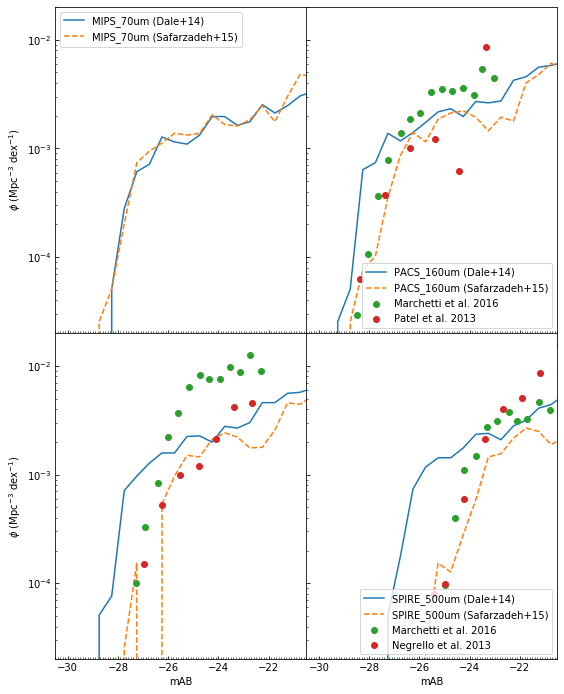

In [52]:
lowlim_list = [-25.3, -25.3, -23.8]
uplim_list = [-29, -29, -28]

row = 2
col = 2
fig, axes = plt.subplots(row, col, sharey=True, figsize=(9,12))

mi = -30.0
ma = -20.0
binwidth = 0.5
NB = int((ma - mi) / binwidth)

for i in range(0, 4):
    ax = plt.subplot(row, col, i+1)
    counts1, binedges1 = np.histogram(mab_IR[i], range=(mi, ma), bins=NB)
    xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, '-', lw=1.5, label=IR_filter_d[i] + ' (Dale+14)')
    
    counts1, binedges1 = np.histogram(mab_IR_s[i], range=(mi, ma), bins=NB)
    xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, '--', lw=1.5, label=IR_filter_d[i] + ' (Safarzadeh+15)')
    '''
    counts1, binedges1 = np.histogram(mab_IR[i], range=(mi, ma), bins=NB)
    xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto1, counts1/ ((BoxSize/Hubble_h)**3) / binwidth, '-.', lw=1.5, label=IR_filter_d[i] + ' (Safarzadeh+15)')
    '''
    plt.yscale('log', nonposy='clip')
    plt.ylim(2e-5, 2e-2)
    plt.xlim(-30.5, -20.5)
    ax.tick_params(axis='both', which='both', direction='in')
    ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...



plt.subplot(221)
plt.legend(loc='upper left')

plt.subplot(222).set_yticklabels([])
plt.subplot(222).set_ylabel('')
#Marchetti_mag, Marchetti_phi = np.loadtxt('files/Marchetti_PACS160.dat', usecols=(0,1), unpack=True)
Marchetti_mag = [-27.811, -27.373, -26.953, -26.573, -26.031, -25.686, -25.271, -24.844,
                -24.413, -23.998, -23.596, -23.121, -22.819, -22.347]
Marchetti_phi = 10 ** np.array([-4.123, -3.558, -3.032, -2.698, -2.451, -2.320, -2.268, -2.071, -2.047, -2.058,
                 -2.031, -2.099, -1.858, -1.946])

plt.errorbar(Marchetti_mag+5.0*np.log10(Hubble_h), Marchetti_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Marchetti et al. 2016')

Patel_mag = [-27.693, -26.674, -25.695, -24.684, -23.721, -22.664]
Patel_phi = 10 ** np.array([-3.789, -3.018, -2.590, -2.501, -2.802, -1.660])
plt.errorbar(Patel_mag+5.0*np.log10(Hubble_h), Patel_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Patel et al. 2013')
plt.legend(loc='lower right')


plt.subplot(223)
Marchetti_mag = [-26.597, -26.222, -25.731, -25.342, -24.946, -24.505,
                -24.066, -23.698, -23.257, -22.841, -22.452, -22.046, -21.620]
Marchetti_phi = 10 ** np.array([-3.584, -3.074, -2.665, -2.246, -2.020,
                               -1.786, -1.671, -1.713, -1.707, -1.601, -1.649,
                               -1.492, -1.636])
plt.errorbar(Marchetti_mag+5.0*np.log10(Hubble_h), Marchetti_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Marchetti et al. 2016')

Dye_mag = [-26.287, -25.574, -24.838, -24.107, -23.421, -22.679, -21.986]
Dye_phi = 10 ** np.array([-3.410, -2.872, -2.591, -2.508, -2.263, -1.966, -1.927])
plt.errorbar(Dye_mag+5.0*np.log10(Hubble_h), Dye_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Dya et al. 2010')
#plt.legend(loc='lower right')
plt.xlabel('mAB')

plt.subplot(224).set_yticklabels([])
plt.subplot(224).set_ylabel('')
Marchetti_mag = [-24.274, -23.888, -23.522, -23.043, -22.633, -22.208, -21.764,
                 -21.409, -21.019, -20.568, -20.129]
Marchetti_phi = 10 ** np.array([-3.606, -2.985, -2.545, -2.422, -2.149, -2.093,
                               -2.013, -2.096, -2.083, -1.919, -1.996])
plt.errorbar(Marchetti_mag+5.0*np.log10(Hubble_h), Marchetti_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Marchetti et al. 2016')

Negrello_mag = [-24.750, -24.278, -23.551, -22.719, -21.975, -21.238, -20.498, -19.731]
Negrello_phi = 10 ** np.array([-3.688, -3.592, -2.816, -2.267, -1.990, -1.883, -1.656, -1.388])
plt.errorbar(Negrello_mag+5.0*np.log10(Hubble_h), Negrello_phi*Hubble_h*Hubble_h*Hubble_h, lw=1.0, marker='o', ls='none',label='Negrello et al. 2013')

#fig.delaxes(axes[-1,-1]) 
plt.legend(loc='lower right')

plt.xlabel('mAB')
plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('plots/FIR-mini.png')

## ----------------------------------------------------------------

In [127]:
w = np.where((mab_IR_s[2] < -26.0))[0]
print(np.log10(Dust[w]))

[7.99970191 8.11591938 7.99149844 7.91868036 7.85718615 7.90676831
 7.82867621 8.07118048 8.20680953 7.65292688 8.06756479 6.88456067
 7.91926831 7.25222505 7.4670733  7.95381207 7.20276942 7.46227116
 7.86538211 7.9142664  7.61068399 7.61414731 8.04789144 7.86936541
 7.73632122 7.75592971 7.61576497 7.47752993]


In [ ]:
Dale_template = np.loadtxt('files/spectra.0.00AGN.dat', unpack=True)
lambda_IR = Dale_template[0] * 1e4 #convert from micron to Angstrom
delta_lambda_IR = lambda_IR[1:1496] - lambda_IR[0:1495]

In [ ]:
Ldust = (spectra - spectra_dusty)
w = np.where(wavelength < 912)[0]
idx_912 = w[-1]
delta = wavelength[idx_912+1:6900] - wavelength[idx_912:6899]

all_wave = np.unique(np.concatenate((wavelength, lambda_IR)))
all_wave.sort(kind='mergesort')
UVIR = np.zeros((len(Ldust), len(all_wave)))

LIR = []
alpha_list = []

for i in range(len(Ldust)):
    LIR_lambda = Ldust[i][idx_912:6899] * delta
    LIR_mentari = sum(LIR_lambda)
    '''
    if (LIR_mentari < 10**9.5):
        LIR_mentari = 10**9.5
    '''
    if (LIR_mentari > 10**11.6):
        LIR_mentari = 10**11.6
        
    alpha = 10.096 - 0.741 * np.log10(LIR_mentari)
    delta_alpha = abs(alpha_SF - alpha)
    idx = np.where(delta_alpha==min(delta_alpha))[0]
    spectra_IR = 10 ** Dale_template[idx[0]+1] 

    LIR_dale = sum(spectra_IR[0:1495] * delta_lambda_IR)
    scaling = LIR_mentari / LIR_dale
    alpha_list.append(alpha_SF[idx[0]])
    spectra_IR_dale = spectra_IR * scaling 
    
    new_spectra = np.interp(all_wave, wavelength, spectra_dusty[i])
    new_IR = np.interp(all_wave, lambda_IR, spectra_IR_dale)
    all_spec = new_spectra + new_IR
    UVIR[i] = all_spec
    LIR.append(spectra_IR_dale)


In [ ]:
w1 = np.where(G_history_dusty[0].MetalsColdGas > 0.0)[0]
mass1 = np.log10(G_history_dusty[0].MetalsColdGas[w1] * 1.e10 / Hubble_h)

w2 = np.where(gas_metals[:,63] / Hubble_h > 0)[0]
mass2 = np.log10(gas_metals[:,63][w2] / Hubble_h)

#w3 = np.where((metals_sage[:,63] > 0) & (mass_sage[:,63] / Hubble_h > 0))[0]
#mass3 = np.log10(mass_sage[:,63][w3] / Hubble_h)

#c_mass = np.log10(MassHist_old[0]*MetalHist_old[0] * (1. - rec_frac) / Hubble_h) #final computed mass #final computed mass

mi = np.floor(min(mass1)) - 2
ma = np.floor(max(mass1)) + 2
ma = 14
NB = int((ma - mi) / binwidth)

#(counts, binedges) = np.histogram(mass, range=(mi, ma), bins=NB)
(counts1, binedges1) = np.histogram(mass1, range=(mi, ma), bins=NB)
(counts2, binedges2) = np.histogram(mass2, range=(mi, ma), bins=NB)
#(counts3, binedges3) = np.histogram(mass3, range=(mi, ma), bins=NB)

# Set the x-axis values to be the centre of the bins
#xaxeshisto = binedges[:-1] + 0.5 * binwidth
xaxeshisto1 = binedges1[:-1] + 0.5 * binwidth
xaxeshisto2 = binedges2[:-1] + 0.5 * binwidth
#xaxeshisto3 = binedges3[:-1] + 0.5 * binwidth

#plt.plot(xaxeshisto, counts / (BoxSize/Hubble_h)**3 / binwidth, 'k-', label='sage')
#plt.plot(xaxeshisto3, counts3 / (BoxSize/Hubble_h)**3 / binwidth, 'g:', label='mentari-sage')
plt.plot(xaxeshisto1, counts1/ (BoxSize/Hubble_h)**3 / binwidth, 'r-', label='dusty-sage')
plt.plot(xaxeshisto2, counts2/ (BoxSize/Hubble_h)**3 / binwidth, 'b:', label='mentari-dustysage')

plt.yscale('log', nonposy='clip')
plt.axis([5.0, 10.0, 1.0e-6, 1.0e-1])


In [ ]:
#given_metals = np.log10(G_history[0].MetalsStellarMass/G_history[0].StellarMass)
given_metals = np.log10(G_history_dusty[0].MetalsStellarMass * 1e10/ Hubble_h)
given_mass = np.log10(G_history_dusty[0].StellarMass * 1e10/ Hubble_h)

w = np.where(Mass[:,63] > 0)[0]
computed_metals_new = np.log10(Metals[:,63][w] * Mass[:,63][w]/ Hubble_h)
computed_mass_new = np.log10(Mass[:,63][w]/ Hubble_h)
'''
w = np.where(MassHist_old[26] > 0)[0]
computed_metals_old = np.log10(MetalHist_old[26][w])
computed_mass_old = np.log10(MassHist_old[26][w])
'''
w = np.where(given_mass > 8)
plt.plot(given_mass[w], given_metals[w], '.', label='dusty sage')

w = np.where(computed_mass_new > 8)
plt.plot(computed_mass_new[w], computed_metals_new[w], '.', label='new model')

#plt.plot(computed_mass_old, computed_metals_old, '.', label='old model')

plt.legend(loc=0)
plt.xlabel(r'$\log_{10} M_{\mathrm{stars}}\ (M_{\odot})$')  # and the x-axis labels
plt.ylabel('Stellar Metallicity')
#plt.savefig('old_metals_z1.png')

In [ ]:
w = np.where(mass_dusty[:,63] == max(mass_dusty[:,63]))[0]
mass_dusty_new = list(mass_dusty[w] / Hubble_h)
metals_dusty_new = list(metals_dusty[w])

In [ ]:
w = np.where(mass_sage[:,63] == max(mass_sage[:,63]))[0]
mass_sage_new = list(mass_sage[w] / Hubble_h)
metals_sage_new = list(metals_sage[w])

In [ ]:
age = np.asarray([0.0124, 0.0246, 0.0491, 0.1037, 0.1871, 0.2120, 0.2399, 0.2709, 0.3054, 0.3438, 0.3864, 0.4335, 0.4856, 0.5430, 0.6062, 0.6756, 0.7517, 0.8349, 0.9259, 1.0249, 1.1327, 1.2496, 1.3763, 1.5131, 1.6606, 1.8192, 1.9895, 2.1717, 2.3662, 2.5734, 2.7934, 3.0265, 3.2726, 3.5318, 3.8038, 4.0886, 4.3856, 4.6944, 5.0144, 5.3488, 5.6849, 6.0337, 6.3901, 6.7531, 7.1215, 7.4940, 7.8694, 8.2464, 8.6238, 9.0004, 9.3750, 9.7463, 10.1133, 10.4750, 10.8303, 11.1783, 11.5181, 11.8490, 12.1702, 12.4811, 12.7810, 13.0695, 13.3459, 13.6098])
lookbacktime = sorted((np.array([13.6098]*len(age)) - age) * 1.e9)

tau_head_ISM = 0.3
tau_head_ISM_2 = 0.65
tau_head_BC = 1
tau_head_BC_2 = 0.3
eta_BC = -0.7
eta_BC_2 = -1.3
eta_ISM = -0.7
eta_ISM_2 = -1.4
time_BC = 10**7

In [ ]:
wavelength, spectra, spectra_dusty  = generate_SED(0,age, mass_dusty, metals_dusty, 
                                    tau_head_BC, tau_head_ISM_2, eta_BC, eta_ISM_2, time_BC)

In [ ]:
wavelength, spectra_2, spectra_dusty_2  = generate_SED(0,age, mass_dusty, metals_dusty, 
                                    tau_head_BC, tau_head_ISM_2, eta_BC, eta_ISM, time_BC)

In [ ]:
wavelength, spectra_3, spectra_dusty_3  = generate_SED(0,age, mass_dusty, metals_dusty, 
                                    tau_head_BC_2, tau_head_ISM, eta_BC, eta_ISM, time_BC)

In [ ]:
wavelength, spectra_5, spectra_dusty_5  = generate_SED(0,age, mass_dusty, metals_dusty, 
                                    tau_head_BC, tau_head_ISM, eta_BC, eta_ISM_2, time_BC)

In [ ]:
wavelength, spectra_4, spectra_dusty_4  = generate_SED(0,age, mass_dusty, metals_dusty, 
                                    tau_head_BC, tau_head_ISM, eta_BC_2, eta_ISM, time_BC)

In [ ]:
print(max(mass_dusty[:,63]),max(mass_sage[:,63]))

In [ ]:
wavelength_dusty_all, spectra_dusty_all = generate_SED(0,age, mass_dusty, metals_dusty)

In [ ]:
wavelength_sage_all, spectra_sage_all = generate_SED(0,age, mass_sage, metals_sage)

In [ ]:
print(wave_IR)

In [ ]:
w = 

In [ ]:
plt.plot(age, np.log10(mass_new[0]), label = "mentari")
#plt.plot(age, np.log10(mass_old), label= "old model")
plt.legend(loc=0)
plt.xlabel(r'$\mathrm{Age}\ \mathrm{Myr}$')
plt.ylabel(r'$\log \mathrm{M_*} \mathrm{(M_\odot)}$')
#plt.savefig('masshist.png')

In [ ]:
plt.plot(age, np.log10(metals_new[0]/mass_new[0]), label = "mentari")
#plt.plot(age, np.log10(metals_old), label= "old model")
plt.legend(loc=0)
plt.xlabel(r'$\mathrm{Age}\ \mathrm{Myr}$')
plt.ylabel(r'$\mathrm{Stellar}\ \mathrm{metallicity}$')
#plt.savefig('metalhist.png')

In [ ]:
import mentari as mtr

In [ ]:
#BoxSize = 62.5
Hubble_h = 0.73

firstfile = 0
lastfile = 1
directory = 'mini-millennium/' #change this to the output directory of sage
filename = 'model'
redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386, 1.276, 1.173, 1.078, 0.989, 0.905, 0.828, 0.755, 0.687, 0.624, 0.564, 0.509, 0.457, 0.408, 0.362, 0.320, 0.280, 0.242, 0.208, 0.175, 0.144, 0.116, 0.089, 0.064, 0.041, 0.020, 0.000]
#redshift = [127.000, 79.998, 50.000, 30.000, 19.916, 18.244, 16.725, 15.343, 14.086, 12.941, 11.897, 10.944, 10.073, 9.278, 8.550, 7.883, 7.272, 6.712, 6.197, 5.724, 5.289, 4.888, 4.520, 4.179, 3.866, 3.576, 3.308, 3.060, 2.831, 2.619, 2.422, 2.239, 2.070, 1.913, 1.766, 1.630, 1.504, 1.386]

In [ ]:
MassHist_old, MetalHist_old = mtr.build_history(redshift, firstfile, lastfile, directory, filename)

In [ ]:
rec_frac = 0.43
c_mass = MassHist_old[0] * (1. - rec_frac) / Hubble_h #final computed mass
w = np.where(c_mass == max(c_mass))[0]

In [ ]:
wavelength_old, spectra_old = mtr.generate_SED(lookbacktime, MassHist_old[:,w], MetalHist_old[:,w]) #wavelength in Angstorm, spectra in Lsun/Angstorm

In [ ]:
#To plot the spectra:

ax = plt.subplot2grid((1,1), (0,0))
#divider = make_axes_locatable(ax)
ax.plot(np.array(wavelength), spectra[0] * np.array(wavelength), lw=0.5, label='no dust')
ax.plot(np.array(wavelength), spectra_dusty[0] * np.array(wavelength), lw=0.5, label='dusty')

#ax.plot(np.array(wavelength_sage), spectra_sage[0] * np.array(wavelength_sage), lw=0.5, label='sage')
#ax.plot(np.array(wavelength_old), spectra_old[0] * np.array(wavelength_old), lw=0.5, label='sage')

plt.legend()

ax.set_xlabel(r'$\lambda\ (\AA) $')
ax.set_ylabel(r'log $\lambda L_{\lambda} (L_{\odot})$')
ax.set_xscale('log')
ax.set_yscale('log')
#plt.savefig('SED-massive.png')

In [ ]:
mab_old = mtr.mab(wavelength_old, spectra_old, filter_list, z)

In [ ]:
mab_new = mtr.mab(wavelength_new, spectra_new, filter_list, z)

In [ ]:
Metallicity = Metals / Mass

In [ ]:
wavelength_all_new, spectra_all_new = generate_SED_v2(0, age, Mass, Metallicity) #wavelength in Angstorm, spectra in Lsun/Angstorm

In [ ]:
%lprun -f generate_SED_v2 generate_SED_v2(0, age, Mass, Metallicity)

In [ ]:
w = np.where(Mass[:,63] > 0)[0]
spectra_all_new_v2 = spectra_all_new[w] / Hubble_h

In [ ]:
mab_dusty_chabrier = compute_mab(wavelength, spectra_dusty / Hubble_h , filter_list, z)

In [ ]:
mab_dusty_2 = compute_mab(wavelength, spectra_dusty_2 / Hubble_h, filter_list, z)

In [ ]:
mab_dusty_3 = compute_mab(wavelength, spectra_dusty_3 / Hubble_h, filter_list, z)

In [ ]:
mab_dusty_4 = compute_mab(wavelength, spectra_dusty_4 / Hubble_h, filter_list, z)

In [ ]:
mab_dusty_5 = compute_mab(wavelength, spectra_dusty_5 / Hubble_h, filter_list, z)

In [ ]:
mab_sage_dusty = compute_mab(wavelength, spectra_sage_dusty / Hubble_h, filter_list, z)

In [ ]:
mab_list_old = mtr.mab(wavelength_all_old, spectra_all_old / Hubble_h, filter_list, z)

In [ ]:
#plot the Luminosity Function vs Kelvin et al. 2013

hubble=0.73
label = ['Mu', 'Mg', 'Mr', 'Mi', 'Mz']
color = ('grey', 'black', 'blue', 'red', 'green', 'purple')

mi = -30.0
ma = -15.0
binwidth = 0.3
NB = int((ma - mi) / binwidth)
M = np.arange(mi, ma, 0.01)

plt.figure()
ax =plt.subplot(111)

# Observations from Kelvin et al. 2013
'''
# SDSS u
Mstar = -18.53
alpha1 = -0.91
phistar1 = 0.00964
alpha2 = 1.25
phistar2 = 0.00146
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)      
plt.plot(M, yval, '--', c=color[1], lw=0.5, label='Kelvin et al (2013)')

# SDSS g
Mstar = -20.28
alpha1 = -1.29
phistar1 = 0.00351
alpha2 = 0.06
phistar2 = 0.00488
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)          
plt.plot(M, yval, '--', c=color[2],lw=0.5)

# SDSS r
Mstar = -20.90
alpha1 = -1.13
phistar1 = 0.00451
alpha2 = 0.53
phistar2 = 0.00301
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)          
plt.plot(M, yval, '--', c=color[3],lw=0.5)

# SDSS i
Mstar = -21.45
alpha1 = -1.35
phistar1 = 0.00220
alpha2 = -0.09
phistar2 = 0.00487
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)              
plt.plot(M, yval, '--', c=color[4], lw=0.5, label='Kelvin et al (2013)')

# SDSS z
Mstar = -21.78
alpha1 = -1.46
phistar1 = 0.0014
alpha2 = -0.26
phistar2 = 0.00505
xval = 10.0 ** (0.4*(Mstar-M))
yval = 0.4 * np.log(10.0) * (phistar1 * xval ** (alpha1+1) + phistar2 * xval ** (alpha2+1)) * np.exp(-xval)                
plt.plot(M, yval, '--', c=color[5], lw=0.5)
'''
twomass_k = [0]
ug = [1, 2]
sdss_r = [3]
sdss_i = [4]
sdss_z = [5]
iz=[4, 5]
sdss =[1,2,3,4,5]

for i in twomass_k:
    
    counts, binedges = np.histogram(mab_dusty[i], range=(mi, ma), bins=NB)
    xaxeshisto = binedges[:-1] + 0.5 * binwidth
    plt.plot(xaxeshisto, counts/ ((BoxSize/Hubble_h)**3) / binwidth, c=color[i], lw=1.0)
        
counts, binedges = np.histogram(mab_dusty[i], range=(mi, ma), bins=NB)
xaxeshisto = binedges[:-1] + 0.5 * binwidth
plt.plot(xaxeshisto, counts/ ((BoxSize/Hubble_h)**3) / binwidth, c=color[i], lw=1.0, label='dusty-sage')

plt.yscale('log', nonposy='clip')
plt.ylabel(r'$\phi\ (\mathrm{Mpc}^{-3}\ \mathrm{dex}^{-1})$')  # Set the y...
plt.xlabel(r'$M$')
plt.ylim(2e-4, 1e-1)
plt.xlim(-24, -16.5)
ax.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
leg = plt.legend(loc='upper left', numpoints=1, labelspacing=0.1)
leg.draw_frame(False)  # Don't want a box frame
for t in leg.get_texts():  # Reduce the size of the text
    t.set_fontsize('medium')
#plt.savefig('k.png')
plt.show()

In [ ]:
MassHist = list(mass_dusty / Hubble_h)
MetalHist = list(metals_dusty)

In [ ]:
def compute_tau(tau_head, eta, wavelength):
    return(tau_head * (wavelength/5500)**eta)

In [ ]:
mab_list = compute_mab(wavelength, total_lum_dusty / Hubble_h, filter_list, z)

In [ ]:
mab_nodust = compute_mab(wavelength, total_lum / Hubble_h, filter_list, z)


In [ ]:
ScaleRad = G_history_dusty[0].DiskRadius * 1e6 / Hubble_h

In [ ]:
def compute_area(rad):
    return (2 * np.pi * rad**2)

In [ ]:
w = np.where(G_history_dusty[0].ColdDust > 0)[0]
ScaleRad = G_history_dusty[0].DiskRadius[w] * 1e6 / Hubble_h #in pc
fdust = G_history_dusty[0].ColdDust[w] / G_history_dusty[0].MetalsColdGas[w]
Zgas = G_history_dusty[0].MetalsColdGas[w] / G_history_dusty[0].ColdGas[w]
rad = 3 * ScaleRad #MilkyWay
halfrad = 1.68 * ScaleRad
twohalfrad = 2 * halfrad
ColdGas = G_history_dusty[0].ColdGas[w] * 1e10 / Hubble_h
ColdDust = G_history_dusty[0].ColdDust[w] * 1e10 / Hubble_h

In [ ]:
w = np.where(mass_dusty[:,63] > 0)[0]
print(max(mass_dusty[w,63]))

In [ ]:
ScaleRad = rad[w[1],63] * 1e6 / Hubble_h
threerad = 3 * ScaleRad
halfrad = 1.68 * ScaleRad
twohalfrad = 2 * ScaleRad
dust_mass = dust[w[1],63] / Hubble_h
gas_mass = gas[w[1],63] / Hubble_h
metals_mass = gas_metals[w[1],63] / Hubble_h

fdust = dust_mass / metals_mass
Zgas = metals_mass / gas_mass


ScaleRad_kpc = rad[w[1],63] * 1e3 / Hubble_h #in kpc
threerad_kpc = 3 * ScaleRad_kpc #MilkyWay
halfrad_kpc = 1.68 * ScaleRad_kpc
twohalfrad_kpc = 2 * halfrad_kpc


In [ ]:
fdust_MW = 0.33
Zsun = 0.0189
Sigma_MW = 85 #Msun/pc2 

In [ ]:
def compute_tau_BC(ColdDust, ColdGas, rad):
    '''
    ColdDust in Msun
    ColdGas in Msun
    rad in Mpc
    '''
    
    fdust = ColdDust / ColdGas
    ScaleRad = rad * 1e6 #convert to pc
    halfrad = 1.68 * ScaleRad 
    
    fdust_MW = 0.33
    Zsun = 0.0189
    Sigma_MW = 85 #Msun/pc2 
    
    area = compute_area(halfrad)
    Sigma_gas = ColdGas / area
    w = np.where(Sigma_gas < Sigma_MW)[0]
    if Sigma_gas < Sigma_MW:
        Sigma_gas = Sigma_MW
    tau_BC = (fdust * Sigma_gas) / (fdust_MW * Zsun * Sigma_MW)
    Sigma_BC = np.log10(fdust * Sigma_gas * 1e6) #kpc
    
    return tau_BC, Sigma_BC

In [ ]:
tau_BC_a, Sigma_BC_a = compute_tau_BC(ColdDust, ColdGas, rad)
#tau_BC_b, Sigma_BC_b = compute_tau_BC(ColdDust, ColdGas, halfrad)
#tau_BC_c, Sigma_BC_c = compute_tau_BC(ColdDust, ColdGas, twohalfrad)

In [ ]:
for tree in iterate_trees(SAM_choice, directory, firstfile, lastfile):


In [ ]:
def compute_tau_ISM(ColdDust, rad):
    '''
    ColdDust in Msun
    rad in Mpc
    '''
    
    ScaleRad = rad * 1e3 #convert to kpc
    halfrad = 1.68 * ScaleRad
    Sigma_dust_Trayford = [4.088, 4.351, 4.579, 4.823, 5.057, 5.292, 5.528, 5.765, 6.001, 6.234, 6.470, 6.704, 6.941, 7.177, 7.416]
    tau_head_Trayford = [0.031, 0.059, 0.078, 0.129, 0.203, 0.308, 0.467, 0.647, 0.838, 1.065, 1.235, 1.475, 1.571, 1.645, 1.806]

    area = compute_area(halfrad)
    Sigma_dust = np.log10(ColdDust / area)
    tau_ISM = np.interp(Sigma_dust, Sigma_dust_Trayford, tau_head_Trayford)
    
    return Sigma_dust, tau_ISM

In [ ]:
def compute_eta_ISM(ColdDust, rad):
    '''
    ColdDust in Msun
    rad in Mpc
    '''
    ScaleRad = rad * 1e3 #convert to kpc
    halfrad = 1.68 * ScaleRad
    
    Sigma_dust_Trayford = [4.116, 4.354, 4.588, 4.822, 5.061, 5.293, 5.533, 5.763, 6.003, 6.236, 6.469, 6.706, 6.943, 7.181, 7.411]
    eta_ISM_Trayford = [-1.379, -1.357, -1.334, -1.243, -1.170, -1.062, -0.922, -0.778, -0.668, -0.570, -0.506, -0.453, -0.381, -0.318, -0.307]
    area = compute_area(halfrad)
    Sigma_dust = np.log10(ColdDust / area)
    eta_ISM = np.interp(Sigma_dust, Sigma_dust_Trayford, eta_ISM_Trayford)
    
    return Sigma_dust, eta_ISM

In [ ]:
tau_BC_a, Sigma_BC_a = compute_tau_BC(dust_mass, gas_mass, threerad)
tau_BC_b, Sigma_BC_b = compute_tau_BC(dust_mass, gas_mass, halfrad)
tau_BC_c, Sigma_BC_c = compute_tau_BC(dust_mass, gas_mass, twohalfrad)

Sigma_tau_a, tau_ISM_a = compute_tau_ISM(dust_mass, threerad_kpc)
Sigma_tau_b, tau_ISM_b = compute_tau_ISM(dust_mass, halfrad_kpc)
Sigma_tau_c, tau_ISM_c = compute_tau_ISM(dust_mass, twohalfrad_kpc)

Sigma_eta_a, eta_ISM_a = compute_eta_ISM(dust_mass, threerad_kpc)
Sigma_eta_b, eta_ISM_b = compute_eta_ISM(dust_mass, halfrad_kpc)
Sigma_eta_c, eta_ISM_c = compute_eta_ISM(dust_mass, twohalfrad_kpc)

In [ ]:
print(Sigma_BC_a, tau_BC_a)
print(Sigma_BC_b, tau_BC_b)
print(Sigma_BC_c, tau_BC_c)
print(tau_BC_a, tau_ISM_a, eta_ISM_a)
print(tau_BC_b, tau_ISM_b, eta_ISM_b)
print(tau_BC_c, tau_ISM_c, eta_ISM_c)

In [ ]:
w = np.where((G_history_dusty[0].DiskRadius > 0) & (G_history_dusty[0].ColdDust > 0))[0]

ScaleRad_kpc = G_history_dusty[0].DiskRadius[w] * 10**3 / Hubble_h #in kpc
rad_kpc = 3 * ScaleRad_kpc #MilkyWay
halfrad_kpc = 1.68 * ScaleRad_kpc
twohalfrad_kpc = 2 * halfrad_kpc

ColdDust = G_history_dusty[0].ColdDust[w] * 1e10 / Hubble_h

area_kpc = compute_area(rad_kpc)
sigma = np.log10(ColdDust / area_kpc)
print(sigma)

In [ ]:
Sigma_tau_a, tau_ISM_a = compute_tau_ISM(ColdDust, rad_kpc)
Sigma_tau_b, tau_ISM_b = compute_tau_ISM(ColdDust, halfrad_kpc)
Sigma_tau_c, tau_ISM_c = compute_tau_ISM(ColdDust, twohalfrad_kpc)

In [ ]:
Sigma_eta_a, eta_ISM_a = compute_eta_ISM(ColdDust, rad_kpc)
Sigma_eta_b, eta_ISM_b = compute_eta_ISM(ColdDust, halfrad_kpc)
Sigma_eta_c, eta_ISM_c = compute_eta_ISM(ColdDust, twohalfrad_kpc)

In [ ]:
tau_head_ISM_list = np.interp(Sigma_dust, Sigma_dust_tau, tau_head_Trayford) 

In [ ]:
eta_ISM_list = np.interp(Sigma_dust, Sigma_dust_tau, eta_ISM_Trayford) 

In [ ]:
plt.hist(Sigma_dust, bins=20, range=(0, 8), density='True', label=r'$\Sigma_\mathrm{dust,ISM}$')
plt.hist(Sigma_dust_BC, bins=20, range=(0, 8), density='True', label=r'$\Sigma_\mathrm{dust,BC}$')
plt.legend(loc=0)
plt.savefig('plots/hist_sigma.png')

In [ ]:
w = np.where(mass_dusty[:,63] > 1e11)[0]
fdust = G_history_dusty[0].ColdDust[w] / G_history_dusty[0].MetalsColdGas[w]
Zgas = G_history_dusty[0].MetalsColdGas[w] / G_history_dusty[0].ColdGas[w]
rad = 3 * G_history_dusty[0].DiskRadius[w] * 10**6 / Hubble_h
area = np.pi * rad**2
Sigma_gas = G_history_dusty[0].ColdGas[w] * 1e10 / Hubble_h / area
w = np.where(Sigma_gas < 85)[0]
Sigma_gas[w] = 85

#computing tau_head_BC
fdust_MW = 0.33
Zsun = 0.0189
Sigma_MW = 85 #Msun/(pc2)
Sigma_dust_BC = np.log10(fdust * Zgas * Sigma_gas * 1e6)
tau_head_BC_list = fdust * Zgas * Sigma_gas / (fdust_MW * Zsun * Sigma_MW)

Sigma_dust_tau = [4.088, 4.351, 4.579, 4.823, 5.057, 5.292, 5.528, 5.765, 6.001, 6.234, 6.470, 6.704, 6.941, 7.177, 7.416]
tau_head_Trayford = [0.031, 0.059, 0.078, 0.129, 0.203, 0.308, 0.467, 0.647, 0.838, 1.065, 1.235, 1.475, 1.571, 1.645, 1.806]

rad_kpc = 3 * G_history_dusty[0].DiskRadius[w] * 10**3 / Hubble_h
area_kpc = 2 * np.pi * rad_kpc**2

fdg = G_history_dusty[0].ColdDust[w] / G_history_dusty[0].ColdGas[w]
sigma_gas = G_history_dusty[0].ColdGas[w] * 1e10 / Hubble_h / area_kpc
w = np.where(Sigma_gas < 85 * 1.e6)[0]
sigma_gas[w] = 85 * 1.e6
sigma_dust_a = np.log10(fdg * sigma_gas)
Sigma_dust_b = np.log10(G_history_dusty[0].ColdDust[w] * 1e10 / Hubble_h / area_kpc)

#computing tau_head_ISM
tau_head_ISM_list = np.interp(Sigma_dust, Sigma_dust_tau, tau_head_Trayford) 

print(tau_head_BC_list, tau_head_ISM_list)


In [ ]:
ColdDust = G_history_dusty[0].ColdDust[w] * 1e10 / Hubble_h

area_kpc = compute_area(rad_kpc)
sigma = np.log10(ColdDust / area_kpc)
print(sigma)

In [ ]:
print(Sigma_dust_BC, Sigma_dust)

In [ ]:
age = np.asarray([0.0124, 0.0246, 0.0491, 0.1037, 0.1871, 0.2120, 0.2399, 0.2709, 0.3054, 0.3438, 0.3864, 0.4335, 0.4856, 0.5430, 0.6062, 0.6756, 0.7517, 0.8349, 0.9259, 1.0249, 1.1327, 1.2496, 1.3763, 1.5131, 1.6606, 1.8192, 1.9895, 2.1717, 2.3662, 2.5734, 2.7934, 3.0265, 3.2726, 3.5318, 3.8038, 4.0886, 4.3856, 4.6944, 5.0144, 5.3488, 5.6849, 6.0337, 6.3901, 6.7531, 7.1215, 7.4940, 7.8694, 8.2464, 8.6238, 9.0004, 9.3750, 9.7463, 10.1133, 10.4750, 10.8303, 11.1783, 11.5181, 11.8490, 12.1702, 12.4811, 12.7810, 13.0695, 13.3459, 13.6098])
lookbacktime = sorted((np.array([13.6098]*len(age)) - age) * 1.e9)

#tau_head_ISM = 0.3
#tau_head_ISM_2 = 0.5
#tau_head_BC = 1
eta_BC = -0.7
#eta_BC_2 = -1.3
#eta_ISM = -0.7
time_BC = 10**7

In [ ]:
wavelength_a, spectra_a, spectra_dusty_a = generate_SED(1, age, mass_dusty[w], metals_dusty[w], 
             tau_BC_a, tau_ISM_a, eta_BC, eta_ISM_a, time_BC)

In [ ]:
wavelength_b, spectra_b, spectra_dusty_b = generate_SED(1, age, mass_dusty[w], metals_dusty[w], 
             tau_BC_b, tau_ISM_b, eta_BC, eta_ISM_b, time_BC)

In [ ]:
wavelength_c, spectra_c, spectra_dusty_c = generate_SED(1, age, mass_dusty[w], metals_dusty[w], 
             tau_BC_c, tau_ISM_c, eta_BC, eta_ISM_c, time_BC)

In [ ]:
tau = np.array(tau_head_ISM_list) * (wavelength/5500)

In [ ]:
def compute_tau(tau_head, eta, wavelength):
    tau
    return(tau_head * (wavelength/5500)**eta)

In [ ]:
print(spectra_dusty_3)

In [ ]:
w = np.where((mass_dusty[:,63] / Hubble_h >5.8e10) & (mass_dusty[:,63] / Hubble_h <6.3e10))[0]

In [ ]:
delta_t = (age[1:63] - age[0:62]) * 1e9
delta_mass = mass_dusty[w[2]][1:63] - mass_dusty[w[2]][0:62]
sfr = delta_mass / Hubble_h / delta_t
age_new = age[1:63] 
lookback = (np.array([13.6098]*len(age_new)) - age_new) * 1.e9

In [ ]:
plt.plot(lookback, sfr, '.-', c='k')

In [ ]:
gamma = 0.2

sfr_tau =5*e**-(gamma*age)
lookback_new = (np.array([13.6098]*len(age)) - age) * 1.e9

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
ax = plt.subplot(211)
ax.set_xticklabels([])
plt.plot(age, sfr_tau, 'k', lw=1.0)
plt.xlim(0, 14)
ax.tick_params(axis='both', direction='in')

ax = plt.subplot(212)
plt.plot(age_new, sfr, 'k', lw=1.0)
plt.xlim(0, 14)
plt.xlabel("Age of Universe (Gyr)")
ax.tick_params(axis='both', direction='in')

fig.text(0.05, 0.4, 'SFR ($\mathrm{M_\odot / yr}$)', rotation=90)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plots/sfr.png')

In [ ]:
plt.plot(wavelength, (spectra[w][2] - spectra_dusty[w][2]) / Hubble_h)
#plt.yscale('log')
plt.xscale('log')
plt.xlim(1000, 10000)

In [ ]:
tau_ISM = compute_tau(tau_head_ISM, eta_ISM, wavelength)

In [ ]:
plt.plot(wavelength, 1.086*tau_ISM)
#plt.xlim(800, 40000)
plt.xscale('log')

In [ ]:
luminosity_distance(0.9)

In [ ]:
from scipy.integrate import simps

filterlist = ['Sdss_u', 'Sdss_r']
F = read_filters()
mab_list = []
for i in range(len(filterlist)):
    filters_wave = eval('F.' + filterlist[i] + '_wave')
    filters = eval('F.' + filterlist[i])
    upper = simps(filters * filters_wave, filters_wave)
    lower = simps(filters / filters_wave, filters_wave)
    lambda_eff = np.sqrt(upper/lower)
    print(lambda_eff)

In [ ]:
def compute_effective_wavelength(filter):
    filters_wave = eval('F.' + filter + '_wave')
    filters = eval('F.' + filter)
    upper = simps(filters * filters_wave, filters_wave)
    lower = simps(filters / filters_wave, filters_wave)
    lambda_eff = np.sqrt(upper/lower)
    
    return(lambda_eff)